In [42]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import re
import statistics as stat
import subprocess

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [60]:
df = pd.read_csv('gcj2015.csv')

### Preprocessing data

In [61]:
df = df[df['solution']==0] # Taking solutions for smaller input set of GCJ
# df = df[df['flines'].str.strip().map(len)>1] ## Getting rid of empty code files

### Select only some languages

In [62]:
d = {
    'c':'c',
    'cpp':'c++',
    'CPP':'c++',
    'py':'python',
    'java':'java',
    'JAVA':'java',
    'cs':'c#',
    'rb':'ruby'
}

def lang_finder(x):
    ext = x.split('.')[-1]
    if ext in d:
        return d[ext]
    return ext

df['lang'] = df.apply(lambda row: lang_finder(row.file), axis=1)
df = df[(df.lang=='c++') | (df.lang=='c') | (df.lang=='java') | (df.lang=='python')]

### See language count

In [63]:
with pd.option_context("display.max_rows", 1000):
    display(df['lang'].value_counts())

c++       45241
java      15637
python    13117
c          2863
Name: lang, dtype: int64

### Taking only one language

In [64]:
df = df[(df.lang=='c++')]

### Problem wise grouping

In [65]:
# #2015
contest_dic = {
    6224486: 'qualification_round',
    4224486: 'round_1A',
    8224486: 'round_1B',
    4244486: 'round_1C',
    8234486: 'round_2',
    4254486: 'round_3',
    5224486: 'final_round'
}

#2016
# contest_dic = {
#     6254486: 'qualification_round',
#     4304486: 'round_1A',
#     11254486: 'round_1B',
#     4314486: 'round_1C',
#     10224486: 'round_2',
#     3224486: 'round_3',
#     7234486: 'final_round'
# }

# #2017
# contest_dic = {
#     3264486: 'qualification_round',
#     5304486: 'round_1A',
#     8294486: 'round_1B',
#     3274486: 'round_1C',
#     5314486: 'round_2',
#     8304486: 'round_3',
#     6314486: 'final_round'
# }



def name_round(row):
    return contest_dic[row['round']]

def extract_problem_no(row):
    return re.search(r'/([0-9]*)/0/', row['full_path']).group(1)

df['round_name'] = df.apply(lambda row: name_round(row), axis=1)
df['problem_num_hash'] = df.apply(lambda row: extract_problem_no(row), axis=1)

In [66]:
df['problem_num_hash'].unique()

array(['5733089514881024', '5695196763258880', '5717048348901376',
       '5657979126808576', '5730531593420800', '5642330950336512',
       '5750872826970112', '5759940174020608', '5708208098246656',
       '5677015495606272', '5769900270288896', '5688567749672960',
       '5662291475300352', '5686275109552128', '5639104758808576',
       '5670465267826688', '5658571765186560', '6404600001200128',
       '6377668744314880', '5765824346324992', '5709131113562112',
       '5765010517131264', '5643297854849024', '6346912416399360',
       '5743952695132160', '5640146288377856', '5646553574277120',
       '5708284669460480'], dtype=object)

### Find finalists & semi finalists (top programmers)

In [67]:
finalists = df[df['round_name']=='final_round'].username.unique()
semi_finalists = df[df['round_name']=='round_3'].username.unique()

def set_finalists(row):
    return row['username'] in finalists

def set_semi_finalists(row):
    return row['username'] in semi_finalists

df['finalist'] = df.apply(lambda row: set_finalists(row), axis=1)
df['semi_finalist'] = df.apply(lambda row: set_semi_finalists(row), axis=1)

In [68]:
# df[df['username']=='Gennady.Korotkevich']
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(df[df['round']==7234486].full_path)
# pd.options.display.max_colwidth = 100
# df[df['round']==7234486].full_path

### Finding Layout features

In [69]:
def code_to_layout(df):
    _num_tabs = []
    _num_spaces = []
    _num_empty_lines = []

    _white_space_ratio = []
    _nl_before_braces = []
    _tabs_lead_lines = []
    
    _file_length_in_char = []
    _avg_line_length = []
    _stdev_line_length = []
    
    for i in df.index:
#         print(i)
        code = str(df.loc[i,'flines'])
    
        file_length_in_char = 0

        num_of_tabs = 1
        num_of_spaces = 1
        empty_lines = 1
        num_of_newline = 0
        num_of_non_white_chars = 0

        starts_with_spaces = 0
        starts_with_tabs = 0

        new_line_before_braces = 0
        not_new_line_before_braces = 0

        line_lengths = []
        
        for line in code.splitlines(True):
            # Remove extra whitespace at beginning (for all lines except first line)
            if file_length_in_char != 0:
                line = line[1:]

            line_lengths.append(len(line))
            
            if len(line)==0:
                print("hello")
                continue
            if line in ['\n', '\r\n']:
                empty_lines += 1

            if line[0] == ' ':
                starts_with_spaces += 1
            elif line[0] == '\t':
                starts_with_tabs += 1

            for i,ch in enumerate(line):
                file_length_in_char += 1

                if ch == ' ':
                    num_of_spaces += 1
                elif ch == '\t':
                    num_of_tabs += 1
                elif ch == '\n':
                    num_of_newline += 1
                else:
                    num_of_non_white_chars += 1

                    if ch == '{':
                        l = line[0:i].strip()

                        if len(l)==0:
                            new_line_before_braces += 1
                        else:
                            not_new_line_before_braces += 1

        # zero length problem solns
        file_length_in_char = file_length_in_char if file_length_in_char>0 else 1
        _file_length_in_char.append(file_length_in_char)
        num_of_non_white_chars = num_of_non_white_chars if num_of_non_white_chars>0 else 1

        #Log of the number of tab/spaces/empty line characters divided by file length in characters
        _num_tabs.append(np.log(num_of_tabs/file_length_in_char))
        _num_spaces.append(np.log(num_of_spaces/file_length_in_char))
        _num_empty_lines.append(np.log(empty_lines/file_length_in_char))

        _white_space_ratio.append((num_of_tabs + num_of_spaces + num_of_newline)/num_of_non_white_chars)
        
        _nl_div =  (new_line_before_braces + not_new_line_before_braces)
        _nl_before_braces.append(new_line_before_braces / _nl_div if _nl_div else 0)
        
        _tab_div = (starts_with_tabs + starts_with_spaces)
        _tabs_lead_lines.append(starts_with_tabs / _tab_div if _tab_div else 0 )
        
        _avg_line_length.append(stat.mean(line_lengths))
        _stdev_line_length.append(stat.pstdev(line_lengths))
    
    
    df['num_tabs'] = _num_tabs
    df['num_spaces'] = _num_spaces
    df['num_empty_lines'] = _num_empty_lines
    df['white_space_ratio'] = _white_space_ratio
    df['nl_before_braces'] = _nl_before_braces
    df['tabs_lead_lines'] = _tabs_lead_lines
    
    # these two are lexical, but easier to compute here
    df['file_length_in_char'] = _file_length_in_char
    df['avg_line_length'] = _avg_line_length
    df['stdev_line_length'] = _stdev_line_length
    
    return df


### Finding lexical features

In [70]:
keyword_types = ['if', 'else', 'elseif', 'while', 'for', 'do', 'break', 'continue', 'switch', 'case', 'default', 'goto',
                 'ternary']
literal_types = ['string', 'char', 'number']
unwanted_chars = ',;><=(){[]}:#'
cntrl_statemnts = ['if', 'switch', 'for', 'while', 'do'] # 'else', 'elseif' left out on purpose

def srcml_parse(code):
    f = open("code.cpp", "w")
    f.write(code)
    f.close()

    # command = "srcml -l C++ --text '$({})'".format(code)
    command = "srcml code.cpp"
    p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

    output = ""
    for line in p.stdout.readlines():
        output += line.decode("utf-8") 
    retval = p.wait()

    if retval!=0:
        print("[-] ERROR IN SrcML doing code: ".format(code))
        raise Exception
    else:
        return output

def remove_namespace(el):
    if '}' in el.tag:
        el.tag = el.tag.split('}', 1)[1]
    return el

def cntrl_depth(elem, depth=-1):
    if depth == -1 and elem.tag not in cntrl_statemnts:
        return 0

    if elem.tag in cntrl_statemnts:
        depth += 1

    # elseif- a critical case specific to elementtree    
    if elem.tag == 'elseif':
        depth -= 1

    max_depth = depth
    for e in elem:
        d = cntrl_depth(e, depth)
        if d > max_depth:
            max_depth = d 

    if max_depth < 0: max_depth = 0
    return max_depth
    
def code_to_lexical(df):
    _occur_if = []
    _occur_else = []
    _occur_elseif = []
    _occur_for = []
    _occur_while = []
    _occur_do = []
    _occur_break = []
    _occur_continue = []
    _occur_switch = []
    _occur_case = []
    _occur_ternary = []
    
    _num_of_tokens = []
    _num_of_uniq_tokens = []

    _comments = []
    _line_comments = []
    _block_comments = []

    _literals = []
    _macros = []
    _nesting_depth = []

    _functions = []
    _parameters_avg = []
    _parameters_stdev = []
    
    to_remove = []
    
    for i in df.index:
        print("[*] Processing {}".format(i))
        code = df.loc[i]['flines']

        try:
            output = srcml_parse(code)
        except:
            to_remove.append(i)
        
        tree = ET.ElementTree(ET.fromstring(output))
        root = tree.getroot()

        keywords = {key:0 for key in keyword_types}
        literals = 0
        uniq_tokens = {}

        comments = 0
        ################# MAYBE ADD THESE TWO LATER???
        line_comment_lengths = []
        block_comment_lengths = []

        functions = 0
        parameters = []

        macros = 0
        max_depth = 0

        # Remove all namespaces
        for elem in root.iter():
            tag = remove_namespace(elem).tag
            # print(remove_namespace(elem).tag, "--", elem.attrib, "--", elem.text)

        ###########################
        for elem in root.iter():
            tag = elem.tag
            attrib = elem.attrib
            text = elem.text

            # Keywords counter + ternary
            if tag in keyword_types:
                keywords[tag] += 1

            # Number of tokens + num of uniq keywords
            token_true = True
            if tag == 'literal':
                if 'type' in attrib and attrib['type'] in literal_types:
                    token_true = False
            if tag == 'operator':
                token_true = False
            if tag == 'comment':
                token_true = False

            if token_true and text is not None:
                t = ''.join(c for c in text if c not in unwanted_chars)
                t = t.strip()

                if t:
                    if t not in uniq_tokens:
                        uniq_tokens[t] = 1
                    else:
                        uniq_tokens[t] += 1

            # Num of Comments
            if tag == 'comment':
                comments += 1
                if attrib['type'] == 'line':
                    line_comment_lengths.append(len(text))
                if attrib['type'] == 'block':
                    block_comment_lengths.append(len(text))

            # Num of Literals
            if tag == 'literal':
                literals += 1

            # Num of directives
            if tag == 'directive':
                macros += 1

            # Max nesting depth
            depth = cntrl_depth(elem)
            max_depth = depth if depth > max_depth else max_depth
            
            # Num of Functions
            if tag == 'function':
                functions += 1
                params = 0
                for p in elem.iter():
                    if p.tag == 'parameter':
                        params += 1
                parameters.append(params)

        #########################

        norm = df.loc[i]['file_length_in_char']
        
        _occur_if.append(keywords['if']/norm)
        _occur_else.append(keywords['else']/norm)
        _occur_elseif.append(keywords['elseif']/norm)
        _occur_for.append(keywords['for']/norm)
        _occur_while.append(keywords['while']/norm)
        _occur_do.append(keywords['do']/norm)
        _occur_break.append(keywords['break']/norm)
        _occur_continue.append(keywords['continue']/norm)
        _occur_switch.append(keywords['switch']/norm)
        _occur_case.append(keywords['case']/norm)
        _occur_ternary.append(keywords['ternary']/norm)

        num_of_tokens = 0
        num_of_uniq_tokens = 0
        for k,v in uniq_tokens.items():
            if v != 0:
                num_of_uniq_tokens += 1
                num_of_tokens += v
        _num_of_tokens.append(num_of_tokens/norm)
        _num_of_uniq_tokens.append(num_of_uniq_tokens/norm)

        _comments.append(comments/norm)
        _line_comments.append(len(line_comment_lengths)/norm)
        _block_comments.append(len(block_comment_lengths)/norm)

        _literals.append(literals/norm)
        _macros.append(macros/norm)
        _nesting_depth.append(max_depth) ########

        _functions.append(functions/norm)
        if functions != 0:
            _parameters_avg.append(stat.mean(parameters)) ####
            _parameters_stdev.append(stat.pstdev(parameters)) #######
        else:
            _parameters_avg.append(0)
            _parameters_stdev.append(0)
        
#     df['occur_if'] = np.log(_occur_if)
#     df['occur_else'] = np.log(_occur_else)
#     df['occur_elseif'] = np.log(_occur_elseif)
#     df['occur_for'] = np.log(_occur_for)
#     df['occur_while'] = np.log(_occur_while)
#     df['occur_do'] = np.log(_occur_do)
#     df['occur_break'] = np.log(_occur_break)
#     df['occur_continue'] = np.log(_occur_continue)
#     df['occur_switch'] = np.log(_occur_switch)
#     df['occur_case'] = np.log(_occur_case)
#     df['occur_ternary'] = np.log(_occur_ternary)

    df['occur_if'] = _occur_if
    df['occur_else'] = _occur_else
    df['occur_elseif'] = _occur_elseif
    df['occur_for'] = _occur_for
    df['occur_while'] = _occur_while
    df['occur_do'] = _occur_do
    df['occur_break'] = _occur_break
    df['occur_continue'] = _occur_continue
    df['occur_switch'] = _occur_switch
    df['occur_case'] = _occur_case
    df['occur_ternary'] = _occur_ternary

    df['num_of_tokens'] = _num_of_tokens
    df['num_of_uniq_tokens'] = _num_of_uniq_tokens
    
    df['comments'] = _comments
    df['line_comments'] = _line_comments
    df['block_comments'] = _block_comments
    
    df['literals'] = _literals
    df['macros'] = _macros
    df['nesting_depth'] = _nesting_depth
    
    df['functions'] = _functions
    df['parameters_avg'] = _parameters_avg
    df['parameters_stdev'] = _parameters_stdev
    
    print(to_remove)
    df.drop(to_remove)
    return df

In [71]:
df = code_to_layout(df)
df.head()

hello
hello
hello


,Unnamed: 0,year,round,username,task,solution,file,full_path,flines,lang,...,semi_finalist,num_tabs,num_spaces,num_empty_lines,white_space_ratio,nl_before_braces,tabs_lead_lines,file_length_in_char,avg_line_length,stdev_line_length
1,1,2015,5224486,vepifanov,5733089514881024,0,sol.cpp,gcj/2015/5224486/vepifanov/5733089514881024/0/...,#include <cstdio>\n #include <numeric>\n #incl...,c++,...,True,-2.930932,-1.910458,-5.764146,0.325485,0.0,0.970588,1912,22.232558,17.951922
3,3,2015,5224486,vepifanov,5695196763258880,0,sol.cpp,gcj/2015/5224486/vepifanov/5695196763258880/0/...,#include <cstdio>\n #include <numeric>\n #incl...,c++,...,True,-3.618750,-1.745550,-5.428858,0.327085,0.0,0.969697,2051,21.819149,19.304372
4,4,2015,5224486,vepifanov,5717048348901376,0,sol.cpp,gcj/2015/5224486/vepifanov/5717048348901376/0/...,#include <cstdio>\n #include <numeric>\n #incl...,c++,...,True,-2.465765,-1.826979,-5.915753,0.411280,0.0,0.980000,2225,21.601942,17.592662
5,5,2015,5224486,vepifanov,5657979126808576,0,sol.cpp,gcj/2015/5224486/vepifanov/5657979126808576/0/...,#include <cstdio>\n #include <numeric>\n #incl...,c++,...,True,-2.732481,-1.837930,-5.655642,0.382126,0.0,0.987952,2859,18.933775,15.569825
7,7,2015,5224486,vepifanov,5730531593420800,0,sol_par.cpp,gcj/2015/5224486/vepifanov/5730531593420800/0/...,#include <cstdio>\n #include <numeric>\n #incl...,c++,...,True,-3.463401,-1.836211,-5.588652,0.303104,0.0,0.970588,2139,23.766667,19.507862


In [72]:
%%time
df = code_to_lexical(df)
df.head()

[*] Processing 1
[*] Processing 3
[*] Processing 4
[*] Processing 5
[*] Processing 7
[*] Processing 9
[*] Processing 11
[*] Processing 12
[*] Processing 13
[*] Processing 14
[*] Processing 16
[*] Processing 18
[*] Processing 20
[*] Processing 21
[*] Processing 22
[*] Processing 24
[*] Processing 26
[*] Processing 28
[*] Processing 30
[*] Processing 32
[*] Processing 34
[*] Processing 35
[*] Processing 37
[*] Processing 38
[*] Processing 39
[*] Processing 41
[*] Processing 42
[*] Processing 44
[*] Processing 45
[*] Processing 47
[*] Processing 48
[*] Processing 50
[*] Processing 52
[*] Processing 54
[*] Processing 55
[*] Processing 57
[*] Processing 58
[*] Processing 60
[*] Processing 62
[*] Processing 64
[*] Processing 65
[*] Processing 66
[*] Processing 68
[*] Processing 70
[*] Processing 72
[*] Processing 74
[*] Processing 75
[*] Processing 76
[*] Processing 78
[*] Processing 80
[*] Processing 81
[*] Processing 82
[*] Processing 90
[*] Processing 92
[*] Processing 93
[*] Processing 9

[*] Processing 916
[*] Processing 917
[*] Processing 919
[*] Processing 927
[*] Processing 928
[*] Processing 930
[*] Processing 931
[*] Processing 932
[*] Processing 934
[*] Processing 935
[*] Processing 938
[*] Processing 939
[*] Processing 941
[*] Processing 943
[*] Processing 945
[*] Processing 952
[*] Processing 953
[*] Processing 955
[*] Processing 957
[*] Processing 959
[*] Processing 965
[*] Processing 968
[*] Processing 970
[*] Processing 977
[*] Processing 978
[*] Processing 980
[*] Processing 987
[*] Processing 994
[*] Processing 997
[*] Processing 998
[*] Processing 1000
[*] Processing 1006
[*] Processing 1007
[*] Processing 1009
[*] Processing 1010
[*] Processing 1012
[*] Processing 1013
[*] Processing 1015
[*] Processing 1017
[*] Processing 1026
[*] Processing 1028
[*] Processing 1030
[*] Processing 1032
[*] Processing 1037
[*] Processing 1039
[*] Processing 1041
[*] Processing 1043
[*] Processing 1045
[*] Processing 1047
[*] Processing 1049
[*] Processing 1051
[*] Proces

[*] Processing 1866
[*] Processing 1867
[*] Processing 1869
[*] Processing 1871
[*] Processing 1873
[*] Processing 1874
[*] Processing 1876
[*] Processing 1878
[*] Processing 1880
[*] Processing 1882
[*] Processing 1884
[*] Processing 1886
[*] Processing 1888
[*] Processing 1889
[*] Processing 1891
[*] Processing 1892
[*] Processing 1894
[*] Processing 1895
[*] Processing 1896
[*] Processing 1898
[*] Processing 1903
[*] Processing 1904
[*] Processing 1906
[*] Processing 1907
[*] Processing 1909
[*] Processing 1910
[*] Processing 1911
[*] Processing 1913
[*] Processing 1916
[*] Processing 1918
[*] Processing 1919
[*] Processing 1920
[*] Processing 1922
[*] Processing 1923
[*] Processing 1925
[*] Processing 1926
[*] Processing 1928
[*] Processing 1929
[*] Processing 1931
[*] Processing 1938
[*] Processing 1940
[*] Processing 1942
[*] Processing 1944
[*] Processing 1946
[*] Processing 1947
[*] Processing 1949
[*] Processing 1950
[*] Processing 1951
[*] Processing 1952
[*] Processing 1953


[*] Processing 2809
[*] Processing 2811
[*] Processing 2813
[*] Processing 2815
[*] Processing 2817
[*] Processing 2819
[*] Processing 2820
[*] Processing 2822
[*] Processing 2824
[*] Processing 2826
[*] Processing 2834
[*] Processing 2835
[*] Processing 2837
[*] Processing 2838
[*] Processing 2840
[*] Processing 2841
[*] Processing 2843
[*] Processing 2844
[*] Processing 2845
[*] Processing 2847
[*] Processing 2848
[*] Processing 2850
[*] Processing 2851
[*] Processing 2853
[*] Processing 2855
[*] Processing 2856
[*] Processing 2858
[*] Processing 2859
[*] Processing 2860
[*] Processing 2862
[*] Processing 2864
[*] Processing 2865
[*] Processing 2867
[*] Processing 2871
[*] Processing 2872
[*] Processing 2873
[*] Processing 2874
[*] Processing 2876
[*] Processing 2877
[*] Processing 2880
[*] Processing 2882
[*] Processing 2883
[*] Processing 2885
[*] Processing 2887
[*] Processing 2889
[*] Processing 2890
[*] Processing 2892
[*] Processing 2893
[*] Processing 2895
[*] Processing 2897


[*] Processing 3759
[*] Processing 3761
[*] Processing 3762
[*] Processing 3764
[*] Processing 3765
[*] Processing 3766
[*] Processing 3768
[*] Processing 3769
[*] Processing 3771
[*] Processing 3772
[*] Processing 3773
[*] Processing 3775
[*] Processing 3782
[*] Processing 3783
[*] Processing 3785
[*] Processing 3790
[*] Processing 3792
[*] Processing 3793
[*] Processing 3795
[*] Processing 3796
[*] Processing 3798
[*] Processing 3800
[*] Processing 3802
[*] Processing 3804
[*] Processing 3806
[*] Processing 3810
[*] Processing 3811
[*] Processing 3813
[*] Processing 3825
[*] Processing 3827
[*] Processing 3829
[*] Processing 3831
[*] Processing 3832
[*] Processing 3834
[*] Processing 3835
[*] Processing 3837
[*] Processing 3839
[*] Processing 3841
[*] Processing 3843
[*] Processing 3844
[*] Processing 3846
[*] Processing 3848
[*] Processing 3850
[*] Processing 3852
[*] Processing 3853
[*] Processing 3854
[*] Processing 3855
[*] Processing 3857
[*] Processing 3865
[*] Processing 3866


[*] Processing 4655
[*] Processing 4657
[*] Processing 4658
[*] Processing 4660
[*] Processing 4661
[*] Processing 4662
[*] Processing 4663
[*] Processing 4665
[*] Processing 4670
[*] Processing 4671
[*] Processing 4673
[*] Processing 4674
[*] Processing 4676
[*] Processing 4678
[*] Processing 4679
[*] Processing 4681
[*] Processing 4683
[*] Processing 4688
[*] Processing 4689
[*] Processing 4690
[*] Processing 4691
[*] Processing 4693
[*] Processing 4694
[*] Processing 4696
[*] Processing 4700
[*] Processing 4702
[*] Processing 4707
[*] Processing 4709
[*] Processing 4710
[*] Processing 4712
[*] Processing 4715
[*] Processing 4716
[*] Processing 4718
[*] Processing 4719
[*] Processing 4721
[*] Processing 4730
[*] Processing 4731
[*] Processing 4733
[*] Processing 4744
[*] Processing 4746
[*] Processing 4747
[*] Processing 4749
[*] Processing 4751
[*] Processing 4753
[*] Processing 4754
[*] Processing 4756
[*] Processing 4758
[*] Processing 4763
[*] Processing 4764
[*] Processing 4766


[*] Processing 5529
[*] Processing 5531
[*] Processing 5533
[*] Processing 5535
[*] Processing 5538
[*] Processing 5539
[*] Processing 5541
[*] Processing 5543
[*] Processing 5544
[*] Processing 5545
[*] Processing 5547
[*] Processing 5549
[*] Processing 5551
[*] Processing 5552
[*] Processing 5554
[*] Processing 5559
[*] Processing 5560
[*] Processing 5561
[*] Processing 5563
[*] Processing 5565
[*] Processing 5567
[*] Processing 5569
[*] Processing 5574
[*] Processing 5575
[*] Processing 5577
[*] Processing 5579
[*] Processing 5581
[*] Processing 5583
[*] Processing 5585
[*] Processing 5586
[*] Processing 5588
[*] Processing 5590
[*] Processing 5591
[*] Processing 5601
[*] Processing 5603
[*] Processing 5604
[*] Processing 5605
[*] Processing 5607
[*] Processing 5610
[*] Processing 5613
[*] Processing 5615
[*] Processing 5616
[*] Processing 5618
[*] Processing 5619
[*] Processing 5621
[*] Processing 5623
[*] Processing 5625
[*] Processing 5627
[*] Processing 5628
[*] Processing 5630


[*] Processing 6464
[*] Processing 6465
[*] Processing 6467
[*] Processing 6468
[*] Processing 6470
[*] Processing 6473
[*] Processing 6474
[*] Processing 6476
[*] Processing 6477
[*] Processing 6479
[*] Processing 6480
[*] Processing 6481
[*] Processing 6483
[*] Processing 6487
[*] Processing 6488
[*] Processing 6490
[*] Processing 6491
[*] Processing 6492
[*] Processing 6494
[*] Processing 6496
[*] Processing 6502
[*] Processing 6504
[*] Processing 6506
[*] Processing 6508
[*] Processing 6509
[*] Processing 6511
[*] Processing 6512
[*] Processing 6513
[*] Processing 6515
[*] Processing 6516
[*] Processing 6518
[*] Processing 6520
[*] Processing 6521
[*] Processing 6522
[*] Processing 6524
[*] Processing 6525
[*] Processing 6526
[*] Processing 6528
[*] Processing 6529
[*] Processing 6530
[*] Processing 6532
[*] Processing 6534
[*] Processing 6536
[*] Processing 6537
[*] Processing 6538
[*] Processing 6540
[*] Processing 6542
[*] Processing 6543
[*] Processing 6544
[*] Processing 6546


[*] Processing 7309
[*] Processing 7310
[*] Processing 7312
[*] Processing 7314
[*] Processing 7316
[*] Processing 7318
[*] Processing 7319
[*] Processing 7321
[*] Processing 7330
[*] Processing 7331
[*] Processing 7333
[*] Processing 7338
[*] Processing 7339
[*] Processing 7341
[*] Processing 7342
[*] Processing 7344
[*] Processing 7345
[*] Processing 7347
[*] Processing 7349
[*] Processing 7351
[*] Processing 7352
[*] Processing 7354
[*] Processing 7360
[*] Processing 7362
[*] Processing 7364
[*] Processing 7366
[*] Processing 7367
[*] Processing 7369
[*] Processing 7374
[*] Processing 7375
[*] Processing 7377
[*] Processing 7388
[*] Processing 7390
[*] Processing 7391
[*] Processing 7393
[*] Processing 7394
[*] Processing 7396
[*] Processing 7403
[*] Processing 7405
[*] Processing 7407
[*] Processing 7409
[*] Processing 7410
[*] Processing 7412
[*] Processing 7413
[*] Processing 7416
[*] Processing 7417
[*] Processing 7419
[*] Processing 7420
[*] Processing 7421
[*] Processing 7423


[*] Processing 8266
[*] Processing 8268
[*] Processing 8270
[*] Processing 8271
[*] Processing 8272
[*] Processing 8274
[*] Processing 8276
[*] Processing 8278
[*] Processing 8280
[*] Processing 8281
[*] Processing 8282
[*] Processing 8284
[*] Processing 8286
[*] Processing 8287
[*] Processing 8289
[*] Processing 8297
[*] Processing 8299
[*] Processing 8303
[*] Processing 8304
[*] Processing 8305
[*] Processing 8307
[*] Processing 8314
[*] Processing 8315
[*] Processing 8317
[*] Processing 8324
[*] Processing 8326
[*] Processing 8328
[*] Processing 8330
[*] Processing 8332
[*] Processing 8347
[*] Processing 8348
[*] Processing 8350
[*] Processing 8351
[*] Processing 8352
[*] Processing 8353
[*] Processing 8355
[*] Processing 8356
[*] Processing 8358
[*] Processing 8359
[*] Processing 8361
[*] Processing 8365
[*] Processing 8366
[*] Processing 8368
[*] Processing 8369
[*] Processing 8371
[*] Processing 8373
[*] Processing 8374
[*] Processing 8376
[*] Processing 8377
[*] Processing 8379


[*] Processing 9188
[*] Processing 9189
[*] Processing 9190
[*] Processing 9191
[*] Processing 9193
[*] Processing 9197
[*] Processing 9198
[*] Processing 9200
[*] Processing 9203
[*] Processing 9205
[*] Processing 9206
[*] Processing 9207
[*] Processing 9208
[*] Processing 9209
[*] Processing 9210
[*] Processing 9211
[*] Processing 9212
[*] Processing 9213
[*] Processing 9214
[*] Processing 9215
[*] Processing 9222
[*] Processing 9226
[*] Processing 9228
[*] Processing 9232
[*] Processing 9234
[*] Processing 9236
[*] Processing 9237
[*] Processing 9240
[*] Processing 9241
[*] Processing 9243
[*] Processing 9245
[*] Processing 9246
[*] Processing 9247
[*] Processing 9249
[*] Processing 9258
[*] Processing 9259
[*] Processing 9266
[*] Processing 9267
[*] Processing 9268
[*] Processing 9269
[*] Processing 9270
[*] Processing 9271
[*] Processing 9275
[*] Processing 9276
[*] Processing 9277
[*] Processing 9278
[*] Processing 9279
[*] Processing 9280
[*] Processing 9281
[*] Processing 9282


[*] Processing 10020
[*] Processing 10021
[*] Processing 10022
[*] Processing 10023
[*] Processing 10024
[*] Processing 10026
[*] Processing 10032
[*] Processing 10034
[*] Processing 10035
[*] Processing 10036
[*] Processing 10037
[*] Processing 10038
[*] Processing 10039
[*] Processing 10040
[*] Processing 10046
[*] Processing 10047
[*] Processing 10049
[*] Processing 10050
[*] Processing 10052
[*] Processing 10054
[*] Processing 10055
[*] Processing 10057
[*] Processing 10058
[*] Processing 10059
[*] Processing 10061
[*] Processing 10062
[*] Processing 10064
[*] Processing 10067
[*] Processing 10068
[*] Processing 10071
[*] Processing 10072
[*] Processing 10073
[*] Processing 10074
[*] Processing 10075
[*] Processing 10076
[*] Processing 10077
[*] Processing 10078
[*] Processing 10079
[*] Processing 10080
[*] Processing 10081
[*] Processing 10087
[*] Processing 10088
[*] Processing 10089
[*] Processing 10090
[*] Processing 10091
[*] Processing 10098
[*] Processing 10099
[*] Processin

[*] Processing 10826
[*] Processing 10827
[*] Processing 10828
[*] Processing 10829
[*] Processing 10831
[*] Processing 10832
[*] Processing 10833
[*] Processing 10834
[*] Processing 10836
[*] Processing 10837
[*] Processing 10839
[*] Processing 10840
[*] Processing 10841
[*] Processing 10845
[*] Processing 10847
[*] Processing 10852
[*] Processing 10853
[*] Processing 10856
[*] Processing 10857
[*] Processing 10858
[*] Processing 10863
[*] Processing 10865
[*] Processing 10867
[*] Processing 10869
[*] Processing 10874
[*] Processing 10877
[*] Processing 10879
[*] Processing 10880
[*] Processing 10881
[*] Processing 10882
[*] Processing 10883
[*] Processing 10884
[*] Processing 10886
[*] Processing 10888
[*] Processing 10890
[*] Processing 10891
[*] Processing 10893
[*] Processing 10894
[*] Processing 10895
[*] Processing 10897
[*] Processing 10899
[*] Processing 10902
[*] Processing 10903
[*] Processing 10905
[*] Processing 10911
[*] Processing 10912
[*] Processing 10914
[*] Processin

[*] Processing 11592
[*] Processing 11593
[*] Processing 11594
[*] Processing 11596
[*] Processing 11597
[*] Processing 11598
[*] Processing 11599
[*] Processing 11600
[*] Processing 11607
[*] Processing 11608
[*] Processing 11617
[*] Processing 11618
[*] Processing 11619
[*] Processing 11620
[*] Processing 11621
[*] Processing 11622
[*] Processing 11623
[*] Processing 11627
[*] Processing 11628
[*] Processing 11629
[*] Processing 11630
[*] Processing 11631
[*] Processing 11632
[*] Processing 11633
[*] Processing 11634
[*] Processing 11635
[*] Processing 11636
[*] Processing 11638
[*] Processing 11642
[*] Processing 11644
[*] Processing 11645
[*] Processing 11647
[*] Processing 11648
[*] Processing 11651
[*] Processing 11652
[*] Processing 11653
[*] Processing 11654
[*] Processing 11655
[*] Processing 11659
[*] Processing 11662
[*] Processing 11665
[*] Processing 11667
[*] Processing 11669
[*] Processing 11670
[*] Processing 11671
[*] Processing 11672
[*] Processing 11676
[*] Processin

[*] Processing 12421
[*] Processing 12422
[*] Processing 12424
[*] Processing 12425
[*] Processing 12426
[*] Processing 12428
[*] Processing 12429
[*] Processing 12430
[*] Processing 12433
[*] Processing 12434
[*] Processing 12435
[*] Processing 12436
[*] Processing 12438
[*] Processing 12442
[*] Processing 12443
[*] Processing 12444
[*] Processing 12445
[*] Processing 12446
[*] Processing 12451
[*] Processing 12452
[*] Processing 12458
[*] Processing 12460
[*] Processing 12461
[*] Processing 12463
[*] Processing 12467
[*] Processing 12468
[*] Processing 12469
[*] Processing 12483
[*] Processing 12484
[*] Processing 12485
[*] Processing 12486
[*] Processing 12490
[*] Processing 12502
[*] Processing 12504
[*] Processing 12513
[*] Processing 12515
[*] Processing 12520
[*] Processing 12523
[*] Processing 12527
[*] Processing 12528
[*] Processing 12532
[*] Processing 12534
[*] Processing 12538
[*] Processing 12540
[*] Processing 12541
[*] Processing 12542
[*] Processing 12544
[*] Processin

[*] Processing 13284
[*] Processing 13286
[*] Processing 13287
[*] Processing 13289
[*] Processing 13293
[*] Processing 13299
[*] Processing 13300
[*] Processing 13301
[*] Processing 13302
[*] Processing 13304
[*] Processing 13306
[*] Processing 13307
[*] Processing 13308
[*] Processing 13309
[*] Processing 13311
[*] Processing 13316
[*] Processing 13318
[*] Processing 13320
[*] Processing 13321
[*] Processing 13322
[*] Processing 13323
[*] Processing 13328
[*] Processing 13330
[*] Processing 13332
[*] Processing 13333
[*] Processing 13335
[*] Processing 13336
[*] Processing 13337
[*] Processing 13339
[*] Processing 13340
[*] Processing 13341
[*] Processing 13342
[*] Processing 13343
[*] Processing 13345
[*] Processing 13346
[*] Processing 13347
[*] Processing 13348
[*] Processing 13350
[*] Processing 13351
[*] Processing 13353
[*] Processing 13354
[*] Processing 13356
[*] Processing 13357
[*] Processing 13358
[*] Processing 13359
[*] Processing 13360
[*] Processing 13362
[*] Processin

[*] Processing 14098
[*] Processing 14099
[*] Processing 14101
[*] Processing 14102
[*] Processing 14104
[*] Processing 14105
[*] Processing 14106
[*] Processing 14107
[*] Processing 14111
[*] Processing 14112
[*] Processing 14113
[*] Processing 14114
[*] Processing 14115
[*] Processing 14116
[*] Processing 14117
[*] Processing 14119
[*] Processing 14125
[*] Processing 14126
[*] Processing 14128
[*] Processing 14129
[*] Processing 14130
[*] Processing 14132
[*] Processing 14133
[*] Processing 14138
[*] Processing 14139
[*] Processing 14141
[*] Processing 14142
[*] Processing 14143
[*] Processing 14144
[*] Processing 14145
[*] Processing 14147
[*] Processing 14148
[*] Processing 14150
[*] Processing 14152
[*] Processing 14153
[*] Processing 14154
[*] Processing 14155
[*] Processing 14156
[*] Processing 14157
[*] Processing 14158
[*] Processing 14160
[*] Processing 14162
[*] Processing 14163
[*] Processing 14165
[*] Processing 14167
[*] Processing 14169
[*] Processing 14181
[*] Processin

[*] Processing 14889
[*] Processing 14890
[*] Processing 14898
[*] Processing 14899
[*] Processing 14901
[*] Processing 14902
[*] Processing 14904
[*] Processing 14907
[*] Processing 14909
[*] Processing 14911
[*] Processing 14912
[*] Processing 14913
[*] Processing 14915
[*] Processing 14916
[*] Processing 14920
[*] Processing 14922
[*] Processing 14924
[*] Processing 14926
[*] Processing 14927
[*] Processing 14928
[*] Processing 14930
[*] Processing 14931
[*] Processing 14932
[*] Processing 14933
[*] Processing 14936
[*] Processing 14937
[*] Processing 14942
[*] Processing 14948
[*] Processing 14954
[*] Processing 14960
[*] Processing 14961
[*] Processing 14962
[*] Processing 14963
[*] Processing 14969
[*] Processing 14970
[*] Processing 14971
[*] Processing 14972
[*] Processing 14973
[*] Processing 14974
[*] Processing 14975
[*] Processing 14978
[*] Processing 14980
[*] Processing 14984
[*] Processing 14986
[*] Processing 14988
[*] Processing 14989
[*] Processing 14990
[*] Processin

[*] Processing 15667
[*] Processing 15669
[*] Processing 15670
[*] Processing 15672
[*] Processing 15678
[*] Processing 15679
[*] Processing 15680
[*] Processing 15682
[*] Processing 15684
[*] Processing 15685
[*] Processing 15690
[*] Processing 15691
[*] Processing 15692
[*] Processing 15693
[*] Processing 15694
[*] Processing 15695
[*] Processing 15699
[*] Processing 15700
[*] Processing 15701
[*] Processing 15702
[*] Processing 15703
[*] Processing 15704
[*] Processing 15705
[*] Processing 15713
[*] Processing 15716
[*] Processing 15717
[*] Processing 15718
[*] Processing 15719
[*] Processing 15720
[*] Processing 15721
[*] Processing 15722
[*] Processing 15723
[*] Processing 15728
[*] Processing 15732
[*] Processing 15733
[*] Processing 15734
[*] Processing 15736
[*] Processing 15738
[*] Processing 15739
[*] Processing 15741
[*] Processing 15742
[*] Processing 15744
[*] Processing 15745
[*] Processing 15747
[*] Processing 15748
[*] Processing 15751
[*] Processing 15752
[*] Processin

[*] Processing 16395
[*] Processing 16397
[*] Processing 16399
[*] Processing 16401
[*] Processing 16405
[*] Processing 16406
[*] Processing 16407
[*] Processing 16408
[*] Processing 16409
[*] Processing 16410
[*] Processing 16411
[*] Processing 16412
[*] Processing 16413
[*] Processing 16414
[*] Processing 16417
[*] Processing 16420
[*] Processing 16422
[*] Processing 16424
[*] Processing 16425
[*] Processing 16427
[*] Processing 16428
[*] Processing 16429
[*] Processing 16430
[*] Processing 16433
[*] Processing 16434
[*] Processing 16435
[*] Processing 16441
[*] Processing 16443
[*] Processing 16452
[*] Processing 16453
[*] Processing 16455
[*] Processing 16458
[*] Processing 16459
[*] Processing 16460
[*] Processing 16461
[*] Processing 16462
[*] Processing 16463
[*] Processing 16464
[*] Processing 16466
[*] Processing 16467
[*] Processing 16468
[*] Processing 16469
[*] Processing 16472
[*] Processing 16473
[*] Processing 16474
[*] Processing 16475
[*] Processing 16478
[*] Processin

[*] Processing 17188
[*] Processing 17189
[*] Processing 17190
[*] Processing 17191
[*] Processing 17192
[*] Processing 17194
[*] Processing 17198
[*] Processing 17200
[*] Processing 17204
[*] Processing 17206
[*] Processing 17208
[*] Processing 17210
[*] Processing 17212
[*] Processing 17213
[*] Processing 17214
[*] Processing 17216
[*] Processing 17217
[*] Processing 17219
[*] Processing 17220
[*] Processing 17221
[*] Processing 17227
[*] Processing 17232
[*] Processing 17234
[*] Processing 17238
[*] Processing 17239
[*] Processing 17240
[*] Processing 17241
[*] Processing 17249
[*] Processing 17250
[*] Processing 17252
[*] Processing 17253
[*] Processing 17255
[*] Processing 17267
[*] Processing 17269
[*] Processing 17270
[*] Processing 17272
[*] Processing 17275
[*] Processing 17276
[*] Processing 17283
[*] Processing 17284
[*] Processing 17285
[*] Processing 17286
[*] Processing 17287
[*] Processing 17290
[*] Processing 17297
[*] Processing 17298
[*] Processing 17299
[*] Processin

[*] Processing 17965
[*] Processing 17966
[*] Processing 17967
[*] Processing 17969
[*] Processing 17971
[*] Processing 17973
[*] Processing 17974
[*] Processing 17975
[*] Processing 17978
[*] Processing 17984
[*] Processing 17985
[*] Processing 17986
[*] Processing 17988
[*] Processing 17989
[*] Processing 17991
[*] Processing 17993
[*] Processing 17994
[*] Processing 17995
[*] Processing 17996
[*] Processing 17997
[*] Processing 17998
[*] Processing 18002
[*] Processing 18004
[*] Processing 18005
[*] Processing 18007
[*] Processing 18008
[*] Processing 18009
[*] Processing 18012
[*] Processing 18014
[*] Processing 18019
[*] Processing 18020
[*] Processing 18021
[*] Processing 18022
[*] Processing 18023
[*] Processing 18028
[*] Processing 18030
[*] Processing 18031
[*] Processing 18033
[*] Processing 18036
[*] Processing 18038
[*] Processing 18040
[*] Processing 18047
[*] Processing 18048
[*] Processing 18049
[*] Processing 18050
[*] Processing 18052
[*] Processing 18054
[*] Processin

[*] Processing 19158
[*] Processing 19181
[*] Processing 19183
[*] Processing 19185
[*] Processing 19187
[*] Processing 19207
[*] Processing 19215
[*] Processing 19217
[*] Processing 19218
[*] Processing 19220
[*] Processing 19222
[*] Processing 19224
[*] Processing 19226
[*] Processing 19228
[*] Processing 19235
[*] Processing 19237
[*] Processing 19239
[*] Processing 19248
[*] Processing 19250
[*] Processing 19252
[*] Processing 19253
[*] Processing 19255
[*] Processing 19264
[*] Processing 19266
[*] Processing 19296
[*] Processing 19297
[*] Processing 19299
[*] Processing 19307
[*] Processing 19313
[*] Processing 19315
[*] Processing 19316
[*] Processing 19318
[*] Processing 19324
[*] Processing 19325
[*] Processing 19327
[*] Processing 19332
[*] Processing 19337
[*] Processing 19338
[*] Processing 19340
[*] Processing 19341
[*] Processing 19343
[*] Processing 19344
[*] Processing 19345
[*] Processing 19346
[*] Processing 19347
[*] Processing 19357
[*] Processing 19359
[*] Processin

[*] Processing 20457
[*] Processing 20459
[*] Processing 20460
[*] Processing 20462
[*] Processing 20463
[*] Processing 20465
[*] Processing 20480
[*] Processing 20481
[*] Processing 20482
[*] Processing 20494
[*] Processing 20496
[*] Processing 20498
[*] Processing 20499
[*] Processing 20501
[*] Processing 20505
[*] Processing 20506
[*] Processing 20507
[*] Processing 20509
[*] Processing 20513
[*] Processing 20515
[*] Processing 20519
[*] Processing 20523
[*] Processing 20529
[*] Processing 20531
[*] Processing 20532
[*] Processing 20534
[*] Processing 20538
[*] Processing 20540
[*] Processing 20542
[*] Processing 20544
[*] Processing 20549
[*] Processing 20551
[*] Processing 20555
[*] Processing 20579
[*] Processing 20581
[*] Processing 20583
[*] Processing 20585
[*] Processing 20587
[*] Processing 20589
[*] Processing 20591
[*] Processing 20592
[*] Processing 20594
[*] Processing 20603
[*] Processing 20605
[*] Processing 20619
[*] Processing 20626
[*] Processing 20628
[*] Processin

[*] Processing 21867
[*] Processing 21869
[*] Processing 21871
[*] Processing 21873
[*] Processing 21875
[*] Processing 21879
[*] Processing 21881
[*] Processing 21891
[*] Processing 21893
[*] Processing 21918
[*] Processing 21934
[*] Processing 21936
[*] Processing 21938
[*] Processing 21943
[*] Processing 21945
[*] Processing 21947
[*] Processing 21949
[*] Processing 21951
[*] Processing 21953
[*] Processing 21954
[*] Processing 21956
[*] Processing 21957
[*] Processing 21959
[*] Processing 21961
[*] Processing 21963
[*] Processing 21965
[*] Processing 21967
[*] Processing 22002
[*] Processing 22004
[*] Processing 22006
[*] Processing 22013
[*] Processing 22039
[*] Processing 22040
[*] Processing 22041
[*] Processing 22042
[*] Processing 22043
[*] Processing 22044
[*] Processing 22046
[*] Processing 22056
[*] Processing 22058
[*] Processing 22060
[*] Processing 22061
[*] Processing 22062
[*] Processing 22064
[*] Processing 22077
[*] Processing 22079
[*] Processing 22081
[*] Processin

[*] Processing 23319
[*] Processing 23321
[*] Processing 23323
[*] Processing 23324
[*] Processing 23326
[*] Processing 23328
[*] Processing 23331
[*] Processing 23332
[*] Processing 23333
[*] Processing 23337
[*] Processing 23339
[*] Processing 23342
[*] Processing 23344
[*] Processing 23345
[*] Processing 23347
[*] Processing 23349
[*] Processing 23351
[*] Processing 23353
[*] Processing 23355
[*] Processing 23356
[*] Processing 23358
[*] Processing 23365
[*] Processing 23366
[*] Processing 23368
[*] Processing 23376
[*] Processing 23378
[*] Processing 23380
[*] Processing 23381
[*] Processing 23382
[*] Processing 23384
[*] Processing 23394
[*] Processing 23402
[*] Processing 23403
[*] Processing 23405
[*] Processing 23407
[*] Processing 23409
[*] Processing 23411
[*] Processing 23412
[*] Processing 23413
[*] Processing 23415
[*] Processing 23424
[*] Processing 23426
[*] Processing 23432
[*] Processing 23434
[*] Processing 23436
[*] Processing 23437
[*] Processing 23439
[*] Processin

[*] Processing 24669
[*] Processing 24671
[*] Processing 24683
[*] Processing 24685
[*] Processing 24687
[*] Processing 24700
[*] Processing 24702
[*] Processing 24703
[*] Processing 24705
[*] Processing 24711
[*] Processing 24713
[*] Processing 24715
[*] Processing 24716
[*] Processing 24717
[*] Processing 24719
[*] Processing 24729
[*] Processing 24731
[*] Processing 24732
[*] Processing 24733
[*] Processing 24735
[*] Processing 24742
[*] Processing 24744
[*] Processing 24760
[*] Processing 24762
[*] Processing 24764
[*] Processing 24765
[*] Processing 24767
[*] Processing 24772
[*] Processing 24774
[*] Processing 24776
[*] Processing 24778
[*] Processing 24781
[*] Processing 24783
[*] Processing 24784
[*] Processing 24786
[*] Processing 24793
[*] Processing 24795
[*] Processing 24796
[*] Processing 24798
[*] Processing 24800
[*] Processing 24805
[*] Processing 24806
[*] Processing 24814
[*] Processing 24816
[*] Processing 24823
[*] Processing 24824
[*] Processing 24825
[*] Processin

[*] Processing 25988
[*] Processing 25990
[*] Processing 25991
[*] Processing 25993
[*] Processing 25995
[*] Processing 25996
[*] Processing 25998
[*] Processing 26000
[*] Processing 26002
[*] Processing 26004
[*] Processing 26006
[*] Processing 26023
[*] Processing 26025
[*] Processing 26027
[*] Processing 26029
[*] Processing 26040
[*] Processing 26041
[*] Processing 26042
[*] Processing 26044
[*] Processing 26065
[*] Processing 26067
[*] Processing 26069
[*] Processing 26071
[*] Processing 26075
[*] Processing 26077
[*] Processing 26079
[*] Processing 26081
[*] Processing 26083
[*] Processing 26091
[*] Processing 26093
[*] Processing 26094
[*] Processing 26103
[*] Processing 26120
[*] Processing 26121
[*] Processing 26123
[*] Processing 26124
[*] Processing 26126
[*] Processing 26128
[*] Processing 26130
[*] Processing 26132
[*] Processing 26133
[*] Processing 26135
[*] Processing 26138
[*] Processing 26139
[*] Processing 26141
[*] Processing 26163
[*] Processing 26164
[*] Processin

[*] Processing 27485
[*] Processing 27487
[*] Processing 27489
[*] Processing 27491
[*] Processing 27498
[*] Processing 27500
[*] Processing 27502
[*] Processing 27504
[*] Processing 27506
[*] Processing 27520
[*] Processing 27522
[*] Processing 27523
[*] Processing 27525
[*] Processing 27527
[*] Processing 27540
[*] Processing 27541
[*] Processing 27544
[*] Processing 27553
[*] Processing 27555
[*] Processing 27557
[*] Processing 27558
[*] Processing 27560
[*] Processing 27561
[*] Processing 27562
[*] Processing 27564
[*] Processing 27565
[*] Processing 27567
[*] Processing 27569
[*] Processing 27575
[*] Processing 27577
[*] Processing 27578
[*] Processing 27580
[*] Processing 27587
[*] Processing 27589
[*] Processing 27591
[*] Processing 27639
[*] Processing 27640
[*] Processing 27642
[*] Processing 27651
[*] Processing 27653
[*] Processing 27655
[*] Processing 27657
[*] Processing 27659
[*] Processing 27661
[*] Processing 27662
[*] Processing 27664
[*] Processing 27674
[*] Processin

[*] Processing 28875
[*] Processing 28877
[*] Processing 28878
[*] Processing 28880
[*] Processing 28882
[*] Processing 28884
[*] Processing 28902
[*] Processing 28904
[*] Processing 28906
[*] Processing 28911
[*] Processing 28913
[*] Processing 28915
[*] Processing 28916
[*] Processing 28918
[*] Processing 28919
[*] Processing 28920
[*] Processing 28922
[*] Processing 28924
[*] Processing 28927
[*] Processing 28937
[*] Processing 28953
[*] Processing 28955
[*] Processing 28957
[*] Processing 28958
[*] Processing 28959
[*] Processing 28961
[*] Processing 28973
[*] Processing 28975
[*] Processing 28991
[*] Processing 28996
[*] Processing 28998
[*] Processing 29003
[*] Processing 29005
[*] Processing 29007
[*] Processing 29009
[*] Processing 29010
[*] Processing 29012
[*] Processing 29017
[*] Processing 29021
[*] Processing 29022
[*] Processing 29024
[*] Processing 29046
[*] Processing 29048
[*] Processing 29050
[*] Processing 29052
[*] Processing 29054
[*] Processing 29055
[*] Processin

[*] Processing 30346
[*] Processing 30348
[*] Processing 30356
[*] Processing 30358
[*] Processing 30360
[*] Processing 30370
[*] Processing 30371
[*] Processing 30373
[*] Processing 30386
[*] Processing 30388
[*] Processing 30394
[*] Processing 30410
[*] Processing 30411
[*] Processing 30413
[*] Processing 30414
[*] Processing 30416
[*] Processing 30426
[*] Processing 30428
[*] Processing 30430
[*] Processing 30432
[*] Processing 30435
[*] Processing 30437
[*] Processing 30446
[*] Processing 30448
[*] Processing 30461
[*] Processing 30463
[*] Processing 30464
[*] Processing 30466
[*] Processing 30467
[*] Processing 30469
[*] Processing 30474
[*] Processing 30476
[*] Processing 30478
[*] Processing 30486
[*] Processing 30488
[*] Processing 30490
[*] Processing 30492
[*] Processing 30496
[*] Processing 30498
[*] Processing 30500
[*] Processing 30502
[*] Processing 30512
[*] Processing 30514
[*] Processing 30516
[*] Processing 30517
[*] Processing 30519
[*] Processing 30521
[*] Processin

[*] Processing 31658
[*] Processing 31666
[*] Processing 31667
[*] Processing 31669
[*] Processing 31671
[*] Processing 31673
[*] Processing 31685
[*] Processing 31687
[*] Processing 31689
[*] Processing 31691
[*] Processing 31694
[*] Processing 31698
[*] Processing 31699
[*] Processing 31701
[*] Processing 31703
[*] Processing 31722
[*] Processing 31724
[*] Processing 31743
[*] Processing 31745
[*] Processing 31746
[*] Processing 31747
[*] Processing 31749
[*] Processing 31751
[*] Processing 31767
[*] Processing 31769
[*] Processing 31771
[*] Processing 31773
[*] Processing 31774
[*] Processing 31775
[*] Processing 31777
[*] Processing 31795
[*] Processing 31799
[*] Processing 31808
[*] Processing 31809
[*] Processing 31811
[*] Processing 31813
[*] Processing 31815
[*] Processing 31816
[*] Processing 31817
[*] Processing 31819
[*] Processing 31821
[*] Processing 31827
[*] Processing 31828
[*] Processing 31830
[*] Processing 31832
[*] Processing 31833
[*] Processing 31835
[*] Processin

[*] Processing 33048
[*] Processing 33050
[*] Processing 33051
[*] Processing 33053
[*] Processing 33063
[*] Processing 33065
[*] Processing 33087
[*] Processing 33088
[*] Processing 33090
[*] Processing 33091
[*] Processing 33093
[*] Processing 33094
[*] Processing 33095
[*] Processing 33097
[*] Processing 33098
[*] Processing 33100
[*] Processing 33101
[*] Processing 33102
[*] Processing 33104
[*] Processing 33117
[*] Processing 33119
[*] Processing 33120
[*] Processing 33124
[*] Processing 33125
[*] Processing 33127
[*] Processing 33129
[*] Processing 33131
[*] Processing 33142
[*] Processing 33144
[*] Processing 33149
[*] Processing 33153
[*] Processing 33156
[*] Processing 33181
[*] Processing 33206
[*] Processing 33208
[*] Processing 33210
[*] Processing 33212
[*] Processing 33213
[*] Processing 33215
[*] Processing 33217
[*] Processing 33219
[*] Processing 33221
[*] Processing 33223
[*] Processing 33230
[*] Processing 33232
[*] Processing 33234
[*] Processing 33236
[*] Processin

[*] Processing 34266
[*] Processing 34267
[*] Processing 34269
[*] Processing 34271
[*] Processing 34278
[*] Processing 34280
[*] Processing 34282
[*] Processing 34284
[*] Processing 34299
[*] Processing 34301
[*] Processing 34307
[*] Processing 34309
[*] Processing 34311
[*] Processing 34313
[*] Processing 34315
[*] Processing 34317
[*] Processing 34318
[*] Processing 34320
[*] Processing 34322
[*] Processing 34324
[*] Processing 34326
[*] Processing 34344
[*] Processing 34368
[*] Processing 34370
[*] Processing 34372
[*] Processing 34373
[*] Processing 34375
[*] Processing 34384
[*] Processing 34385
[*] Processing 34387
[*] Processing 34398
[*] Processing 34399
[*] Processing 34401
[*] Processing 34403
[*] Processing 34420
[*] Processing 34422
[*] Processing 34424
[*] Processing 34429
[*] Processing 34430
[*] Processing 34431
[*] Processing 34433
[*] Processing 34434
[*] Processing 34436
[*] Processing 34442
[*] Processing 34444
[*] Processing 34446
[*] Processing 34448
[*] Processin

[*] Processing 35731
[*] Processing 35732
[*] Processing 35743
[*] Processing 35745
[*] Processing 35747
[*] Processing 35749
[*] Processing 35751
[*] Processing 35753
[*] Processing 35755
[*] Processing 35764
[*] Processing 35766
[*] Processing 35767
[*] Processing 35768
[*] Processing 35770
[*] Processing 35772
[*] Processing 35774
[*] Processing 35779
[*] Processing 35780
[*] Processing 35781
[*] Processing 35783
[*] Processing 35793
[*] Processing 35802
[*] Processing 35804
[*] Processing 35805
[*] Processing 35807
[*] Processing 35813
[*] Processing 35814
[*] Processing 35817
[*] Processing 35819
[*] Processing 35821
[*] Processing 35823
[*] Processing 35825
[*] Processing 35827
[*] Processing 35854
[*] Processing 35856
[*] Processing 35858
[*] Processing 35860
[*] Processing 35878
[*] Processing 35880
[*] Processing 35885
[*] Processing 35886
[*] Processing 35887
[*] Processing 35889
[*] Processing 35890
[*] Processing 35892
[*] Processing 35893
[*] Processing 35894
[*] Processin

[*] Processing 37086
[*] Processing 37088
[*] Processing 37090
[*] Processing 37101
[*] Processing 37108
[*] Processing 37110
[*] Processing 37112
[*] Processing 37114
[*] Processing 37116
[*] Processing 37118
[*] Processing 37119
[*] Processing 37121
[*] Processing 37124
[*] Processing 37125
[*] Processing 37127
[*] Processing 37148
[*] Processing 37149
[*] Processing 37151
[*] Processing 37152
[*] Processing 37153
[*] Processing 37154
[*] Processing 37156
[*] Processing 37164
[*] Processing 37166
[*] Processing 37193
[*] Processing 37194
[*] Processing 37196
[*] Processing 37207
[*] Processing 37208
[*] Processing 37210
[*] Processing 37214
[*] Processing 37216
[*] Processing 37218
[*] Processing 37223
[*] Processing 37225
[*] Processing 37227
[*] Processing 37229
[*] Processing 37230
[*] Processing 37232
[*] Processing 37233
[*] Processing 37235
[*] Processing 37244
[*] Processing 37245
[*] Processing 37247
[*] Processing 37249
[*] Processing 37251
[*] Processing 37253
[*] Processin

[*] Processing 38548
[*] Processing 38550
[*] Processing 38552
[*] Processing 38554
[*] Processing 38561
[*] Processing 38562
[*] Processing 38564
[*] Processing 38568
[*] Processing 38570
[*] Processing 38572
[*] Processing 38573
[*] Processing 38574
[*] Processing 38576
[*] Processing 38578
[*] Processing 38591
[*] Processing 38593
[*] Processing 38595
[*] Processing 38613
[*] Processing 38615
[*] Processing 38617
[*] Processing 38619
[*] Processing 38623
[*] Processing 38624
[*] Processing 38625
[*] Processing 38627
[*] Processing 38637
[*] Processing 38639
[*] Processing 38641
[*] Processing 38642
[*] Processing 38644
[*] Processing 38645
[*] Processing 38647
[*] Processing 38653
[*] Processing 38654
[*] Processing 38655
[*] Processing 38657
[*] Processing 38670
[*] Processing 38672
[*] Processing 38674
[*] Processing 38677
[*] Processing 38678
[*] Processing 38680
[*] Processing 38681
[*] Processing 38683
[*] Processing 38686
[*] Processing 38688
[*] Processing 38690
[*] Processin

[*] Processing 39779
[*] Processing 39781
[*] Processing 39782
[*] Processing 39784
[*] Processing 39794
[*] Processing 39799
[*] Processing 39801
[*] Processing 39803
[*] Processing 39818
[*] Processing 39819
[*] Processing 39821
[*] Processing 39822
[*] Processing 39824
[*] Processing 39846
[*] Processing 39853
[*] Processing 39854
[*] Processing 39856
[*] Processing 39858
[*] Processing 39860
[*] Processing 39861
[*] Processing 39864
[*] Processing 39865
[*] Processing 39867
[*] Processing 39868
[*] Processing 39870
[*] Processing 39872
[*] Processing 39874
[*] Processing 39875
[*] Processing 39877
[*] Processing 39879
[*] Processing 39880
[*] Processing 39882
[*] Processing 39884
[*] Processing 39889
[*] Processing 39891
[*] Processing 39893
[*] Processing 39895
[*] Processing 39904
[*] Processing 39906
[*] Processing 39908
[*] Processing 39910
[*] Processing 39913
[*] Processing 39915
[*] Processing 39917
[*] Processing 39919
[*] Processing 39924
[*] Processing 39926
[*] Processin

[*] Processing 41266
[*] Processing 41267
[*] Processing 41269
[*] Processing 41271
[*] Processing 41273
[*] Processing 41298
[*] Processing 41300
[*] Processing 41301
[*] Processing 41302
[*] Processing 41304
[*] Processing 41306
[*] Processing 41308
[*] Processing 41309
[*] Processing 41310
[*] Processing 41311
[*] Processing 41313
[*] Processing 41321
[*] Processing 41323
[*] Processing 41325
[*] Processing 41327
[*] Processing 41328
[*] Processing 41330
[*] Processing 41332
[*] Processing 41334
[*] Processing 41336
[*] Processing 41338
[*] Processing 41340
[*] Processing 41354
[*] Processing 41356
[*] Processing 41358
[*] Processing 41363
[*] Processing 41365
[*] Processing 41366
[*] Processing 41367
[*] Processing 41369
[*] Processing 41371
[*] Processing 41373
[*] Processing 41388
[*] Processing 41390
[*] Processing 41392
[*] Processing 41399
[*] Processing 41401
[*] Processing 41403
[*] Processing 41404
[*] Processing 41406
[*] Processing 41408
[*] Processing 41410
[*] Processin

[*] Processing 42619
[*] Processing 42620
[*] Processing 42621
[*] Processing 42623
[*] Processing 42628
[*] Processing 42630
[*] Processing 42633
[*] Processing 42635
[*] Processing 42636
[*] Processing 42637
[*] Processing 42639
[*] Processing 42650
[*] Processing 42652
[*] Processing 42658
[*] Processing 42659
[*] Processing 42661
[*] Processing 42663
[*] Processing 42665
[*] Processing 42667
[*] Processing 42669
[*] Processing 42670
[*] Processing 42672
[*] Processing 42690
[*] Processing 42692
[*] Processing 42694
[*] Processing 42696
[*] Processing 42698
[*] Processing 42700
[*] Processing 42702
[*] Processing 42703
[*] Processing 42704
[*] Processing 42706
[*] Processing 42707
[*] Processing 42709
[*] Processing 42716
[*] Processing 42728
[*] Processing 42729
[*] Processing 42731
[*] Processing 42732
[*] Processing 42734
[*] Processing 42736
[*] Processing 42738
[*] Processing 42743
[*] Processing 42779
[*] Processing 42781
[*] Processing 42782
[*] Processing 42783
[*] Processin

[*] Processing 43840
[*] Processing 43842
[*] Processing 43844
[*] Processing 43846
[*] Processing 43847
[*] Processing 43849
[*] Processing 43853
[*] Processing 43854
[*] Processing 43856
[*] Processing 43874
[*] Processing 43875
[*] Processing 43877
[*] Processing 43883
[*] Processing 43885
[*] Processing 43887
[*] Processing 43888
[*] Processing 43890
[*] Processing 43894
[*] Processing 43896
[*] Processing 43898
[*] Processing 43899
[*] Processing 43929
[*] Processing 43930
[*] Processing 43932
[*] Processing 43943
[*] Processing 43945
[*] Processing 43947
[*] Processing 43949
[*] Processing 43961
[*] Processing 43963
[*] Processing 43964
[*] Processing 43966
[*] Processing 43971
[*] Processing 43982
[*] Processing 43986
[*] Processing 43988
[*] Processing 43989
[*] Processing 43990
[*] Processing 43992
[*] Processing 43998
[*] Processing 44021
[*] Processing 44022
[*] Processing 44024
[*] Processing 44033
[*] Processing 44034
[*] Processing 44035
[*] Processing 44037
[*] Processin

[*] Processing 45330
[*] Processing 45343
[*] Processing 45345
[*] Processing 45346
[*] Processing 45347
[*] Processing 45349
[*] Processing 45350
[*] Processing 45352
[*] Processing 45354
[*] Processing 45355
[*] Processing 45357
[*] Processing 45369
[*] Processing 45370
[*] Processing 45372
[*] Processing 45374
[*] Processing 45382
[*] Processing 45383
[*] Processing 45384
[*] Processing 45385
[*] Processing 45387
[*] Processing 45389
[*] Processing 45391
[*] Processing 45400
[*] Processing 45402
[*] Processing 45403
[*] Processing 45405
[*] Processing 45407
[*] Processing 45408
[*] Processing 45410
[*] Processing 45414
[*] Processing 45415
[*] Processing 45417
[*] Processing 45419
[*] Processing 45421
[*] Processing 45423
[*] Processing 45425
[*] Processing 45427
[*] Processing 45430
[*] Processing 45432
[*] Processing 45434
[*] Processing 45443
[*] Processing 45445
[*] Processing 45447
[*] Processing 45449
[*] Processing 45450
[*] Processing 45452
[*] Processing 45462
[*] Processin

[*] Processing 46665
[*] Processing 46667
[*] Processing 46669
[*] Processing 46676
[*] Processing 46677
[*] Processing 46679
[*] Processing 46681
[*] Processing 46683
[*] Processing 46684
[*] Processing 46689
[*] Processing 46691
[*] Processing 46693
[*] Processing 46706
[*] Processing 46707
[*] Processing 46709
[*] Processing 46714
[*] Processing 46716
[*] Processing 46717
[*] Processing 46719
[*] Processing 46721
[*] Processing 46723
[*] Processing 46727
[*] Processing 46729
[*] Processing 46731
[*] Processing 46733
[*] Processing 46738
[*] Processing 46740
[*] Processing 46748
[*] Processing 46749
[*] Processing 46759
[*] Processing 46762
[*] Processing 46764
[*] Processing 46767
[*] Processing 46768
[*] Processing 46770
[*] Processing 46772
[*] Processing 46774
[*] Processing 46776
[*] Processing 46778
[*] Processing 46792
[*] Processing 46794
[*] Processing 46796
[*] Processing 46798
[*] Processing 46799
[*] Processing 46800
[*] Processing 46802
[*] Processing 46809
[*] Processin

[*] Processing 48050
[*] Processing 48051
[*] Processing 48052
[*] Processing 48053
[*] Processing 48056
[*] Processing 48057
[*] Processing 48058
[*] Processing 48060
[*] Processing 48065
[*] Processing 48067
[*] Processing 48069
[*] Processing 48078
[*] Processing 48080
[*] Processing 48081
[*] Processing 48082
[*] Processing 48083
[*] Processing 48085
[*] Processing 48087
[*] Processing 48088
[*] Processing 48089
[*] Processing 48090
[*] Processing 48092
[*] Processing 48093
[*] Processing 48094
[*] Processing 48096
[*] Processing 48098
[*] Processing 48100
[*] Processing 48102
[*] Processing 48103
[*] Processing 48105
[*] Processing 48107
[*] Processing 48109
[*] Processing 48111
[*] Processing 48113
[*] Processing 48127
[*] Processing 48129
[*] Processing 48143
[*] Processing 48145
[*] Processing 48151
[*] Processing 48152
[*] Processing 48154
[*] Processing 48156
[*] Processing 48157
[*] Processing 48159
[*] Processing 48189
[*] Processing 48191
[*] Processing 48202
[*] Processin

[*] Processing 49338
[*] Processing 49340
[*] Processing 49346
[*] Processing 49348
[*] Processing 49360
[*] Processing 49361
[*] Processing 49363
[*] Processing 49365
[*] Processing 49370
[*] Processing 49372
[*] Processing 49374
[*] Processing 49383
[*] Processing 49387
[*] Processing 49389
[*] Processing 49397
[*] Processing 49398
[*] Processing 49400
[*] Processing 49401
[*] Processing 49402
[*] Processing 49404
[*] Processing 49406
[*] Processing 49408
[*] Processing 49411
[*] Processing 49413
[*] Processing 49415
[*] Processing 49417
[*] Processing 49419
[*] Processing 49420
[*] Processing 49422
[*] Processing 49423
[*] Processing 49424
[*] Processing 49426
[*] Processing 49427
[*] Processing 49429
[*] Processing 49432
[*] Processing 49433
[*] Processing 49435
[*] Processing 49457
[*] Processing 49459
[*] Processing 49474
[*] Processing 49476
[*] Processing 49478
[*] Processing 49480
[*] Processing 49482
[*] Processing 49484
[*] Processing 49489
[*] Processing 49491
[*] Processin

[*] Processing 50787
[*] Processing 50793
[*] Processing 50794
[*] Processing 50796
[*] Processing 50801
[*] Processing 50803
[*] Processing 50812
[*] Processing 50813
[*] Processing 50815
[*] Processing 50830
[*] Processing 50832
[*] Processing 50834
[*] Processing 50846
[*] Processing 50848
[*] Processing 50850
[*] Processing 50863
[*] Processing 50869
[*] Processing 50871
[*] Processing 50872
[*] Processing 50874
[*] Processing 50878
[*] Processing 50880
[*] Processing 50882
[*] Processing 50884
[*] Processing 50885
[*] Processing 50886
[*] Processing 50887
[*] Processing 50889
[*] Processing 50904
[*] Processing 50905
[*] Processing 50906
[*] Processing 50908
[*] Processing 50915
[*] Processing 50926
[*] Processing 50928
[*] Processing 50935
[*] Processing 50937
[*] Processing 50939
[*] Processing 50952
[*] Processing 50954
[*] Processing 50973
[*] Processing 50974
[*] Processing 50975
[*] Processing 50977
[*] Processing 50983
[*] Processing 50985
[*] Processing 50989
[*] Processin

[*] Processing 52218
[*] Processing 52226
[*] Processing 52228
[*] Processing 52230
[*] Processing 52232
[*] Processing 52234
[*] Processing 52241
[*] Processing 52248
[*] Processing 52255
[*] Processing 52257
[*] Processing 52259
[*] Processing 52266
[*] Processing 52268
[*] Processing 52269
[*] Processing 52271
[*] Processing 52281
[*] Processing 52283
[*] Processing 52285
[*] Processing 52287
[*] Processing 52289
[*] Processing 52290
[*] Processing 52292
[*] Processing 52294
[*] Processing 52296
[*] Processing 52298
[*] Processing 52300
[*] Processing 52301
[*] Processing 52302
[*] Processing 52304
[*] Processing 52308
[*] Processing 52310
[*] Processing 52312
[*] Processing 52314
[*] Processing 52316
[*] Processing 52318
[*] Processing 52320
[*] Processing 52323
[*] Processing 52325
[*] Processing 52331
[*] Processing 52333
[*] Processing 52335
[*] Processing 52353
[*] Processing 52354
[*] Processing 52367
[*] Processing 52378
[*] Processing 52380
[*] Processing 52382
[*] Processin

[*] Processing 53929
[*] Processing 53931
[*] Processing 53932
[*] Processing 53934
[*] Processing 53972
[*] Processing 53974
[*] Processing 53976
[*] Processing 53977
[*] Processing 53979
[*] Processing 53981
[*] Processing 53989
[*] Processing 53994
[*] Processing 53996
[*] Processing 54007
[*] Processing 54020
[*] Processing 54022
[*] Processing 54024
[*] Processing 54026
[*] Processing 54028
[*] Processing 54040
[*] Processing 54042
[*] Processing 54044
[*] Processing 54051
[*] Processing 54055
[*] Processing 54057
[*] Processing 54058
[*] Processing 54060
[*] Processing 54064
[*] Processing 54065
[*] Processing 54067
[*] Processing 54069
[*] Processing 54071
[*] Processing 54073
[*] Processing 54075
[*] Processing 54077
[*] Processing 54086
[*] Processing 54087
[*] Processing 54089
[*] Processing 54100
[*] Processing 54101
[*] Processing 54103
[*] Processing 54112
[*] Processing 54114
[*] Processing 54116
[*] Processing 54118
[*] Processing 54120
[*] Processing 54130
[*] Processin

[*] Processing 55424
[*] Processing 55433
[*] Processing 55435
[*] Processing 55436
[*] Processing 55451
[*] Processing 55453
[*] Processing 55455
[*] Processing 55457
[*] Processing 55465
[*] Processing 55467
[*] Processing 55469
[*] Processing 55471
[*] Processing 55476
[*] Processing 55478
[*] Processing 55480
[*] Processing 55481
[*] Processing 55482
[*] Processing 55484
[*] Processing 55492
[*] Processing 55494
[*] Processing 55495
[*] Processing 55497
[*] Processing 55506
[*] Processing 55525
[*] Processing 55533
[*] Processing 55535
[*] Processing 55537
[*] Processing 55539
[*] Processing 55548
[*] Processing 55550
[*] Processing 55552
[*] Processing 55553
[*] Processing 55555
[*] Processing 55556
[*] Processing 55558
[*] Processing 55559
[*] Processing 55560
[*] Processing 55562
[*] Processing 55585
[*] Processing 55587
[*] Processing 55589
[*] Processing 55591
[*] Processing 55601
[*] Processing 55602
[*] Processing 55615
[*] Processing 55617
[*] Processing 55619
[*] Processin

[*] Processing 56814
[*] Processing 56815
[*] Processing 56817
[*] Processing 56819
[*] Processing 56821
[*] Processing 56823
[*] Processing 56824
[*] Processing 56826
[*] Processing 56828
[*] Processing 56829
[*] Processing 56831
[*] Processing 56846
[*] Processing 56847
[*] Processing 56849
[*] Processing 56853
[*] Processing 56855
[*] Processing 56857
[*] Processing 56859
[*] Processing 56862
[*] Processing 56863
[*] Processing 56865
[*] Processing 56867
[*] Processing 56868
[*] Processing 56870
[*] Processing 56894
[*] Processing 56896
[*] Processing 56897
[*] Processing 56899
[*] Processing 56901
[*] Processing 56902
[*] Processing 56903
[*] Processing 56905
[*] Processing 56906
[*] Processing 56908
[*] Processing 56909
[*] Processing 56911
[*] Processing 56913
[*] Processing 56915
[*] Processing 56917
[*] Processing 56925
[*] Processing 56927
[*] Processing 56929
[*] Processing 56931
[*] Processing 56933
[*] Processing 56937
[*] Processing 56939
[*] Processing 56941
[*] Processin

[*] Processing 58209
[*] Processing 58216
[*] Processing 58218
[*] Processing 58220
[*] Processing 58221
[*] Processing 58222
[*] Processing 58224
[*] Processing 58228
[*] Processing 58230
[*] Processing 58238
[*] Processing 58240
[*] Processing 58242
[*] Processing 58244
[*] Processing 58246
[*] Processing 58247
[*] Processing 58249
[*] Processing 58251
[*] Processing 58253
[*] Processing 58255
[*] Processing 58256
[*] Processing 58257
[*] Processing 58259
[*] Processing 58261
[*] Processing 58262
[*] Processing 58263
[*] Processing 58265
[*] Processing 58266
[*] Processing 58267
[*] Processing 58268
[*] Processing 58270
[*] Processing 58276
[*] Processing 58278
[*] Processing 58280
[*] Processing 58282
[*] Processing 58284
[*] Processing 58286
[*] Processing 58287
[*] Processing 58298
[*] Processing 58300
[*] Processing 58306
[*] Processing 58308
[*] Processing 58310
[*] Processing 58312
[*] Processing 58313
[*] Processing 58315
[*] Processing 58316
[*] Processing 58317
[*] Processin

[*] Processing 59581
[*] Processing 59582
[*] Processing 59583
[*] Processing 59585
[*] Processing 59598
[*] Processing 59600
[*] Processing 59601
[*] Processing 59602
[*] Processing 59604
[*] Processing 59617
[*] Processing 59619
[*] Processing 59621
[*] Processing 59623
[*] Processing 59631
[*] Processing 59632
[*] Processing 59633
[*] Processing 59635
[*] Processing 59637
[*] Processing 59639
[*] Processing 59641
[*] Processing 59643
[*] Processing 59647
[*] Processing 59649
[*] Processing 59651
[*] Processing 59653
[*] Processing 59655
[*] Processing 59657
[*] Processing 59659
[*] Processing 59660
[*] Processing 59663
[*] Processing 59665
[*] Processing 59666
[*] Processing 59668
[*] Processing 59677
[*] Processing 59679
[*] Processing 59681
[*] Processing 59682
[*] Processing 59684
[*] Processing 59685
[*] Processing 59687
[*] Processing 59689
[*] Processing 59690
[*] Processing 59711
[*] Processing 59713
[*] Processing 59714
[*] Processing 59716
[*] Processing 59717
[*] Processin

[*] Processing 61021
[*] Processing 61023
[*] Processing 61025
[*] Processing 61038
[*] Processing 61040
[*] Processing 61041
[*] Processing 61043
[*] Processing 61045
[*] Processing 61047
[*] Processing 61049
[*] Processing 61051
[*] Processing 61068
[*] Processing 61070
[*] Processing 61072
[*] Processing 61074
[*] Processing 61075
[*] Processing 61080
[*] Processing 61082
[*] Processing 61084
[*] Processing 61096
[*] Processing 61097
[*] Processing 61099
[*] Processing 61107
[*] Processing 61109
[*] Processing 61110
[*] Processing 61112
[*] Processing 61113
[*] Processing 61115
[*] Processing 61117
[*] Processing 61119
[*] Processing 61120
[*] Processing 61121
[*] Processing 61123
[*] Processing 61125
[*] Processing 61127
[*] Processing 61129
[*] Processing 61130
[*] Processing 61132
[*] Processing 61134
[*] Processing 61136
[*] Processing 61138
[*] Processing 61140
[*] Processing 61142
[*] Processing 61143
[*] Processing 61145
[*] Processing 61147
[*] Processing 61149
[*] Processin

[*] Processing 62349
[*] Processing 62351
[*] Processing 62353
[*] Processing 62361
[*] Processing 62363
[*] Processing 62369
[*] Processing 62371
[*] Processing 62373
[*] Processing 62374
[*] Processing 62376
[*] Processing 62383
[*] Processing 62385
[*] Processing 62425
[*] Processing 62427
[*] Processing 62436
[*] Processing 62440
[*] Processing 62442
[*] Processing 62444
[*] Processing 62446
[*] Processing 62448
[*] Processing 62450
[*] Processing 62451
[*] Processing 62453
[*] Processing 62455
[*] Processing 62456
[*] Processing 62457
[*] Processing 62458
[*] Processing 62459
[*] Processing 62460
[*] Processing 62462
[*] Processing 62481
[*] Processing 62483
[*] Processing 62484
[*] Processing 62485
[*] Processing 62486
[*] Processing 62488
[*] Processing 62501
[*] Processing 62502
[*] Processing 62503
[*] Processing 62505
[*] Processing 62517
[*] Processing 62519
[*] Processing 62521
[*] Processing 62524
[*] Processing 62526
[*] Processing 62528
[*] Processing 62538
[*] Processin

[*] Processing 63763
[*] Processing 63765
[*] Processing 63767
[*] Processing 63769
[*] Processing 63770
[*] Processing 63771
[*] Processing 63773
[*] Processing 63774
[*] Processing 63775
[*] Processing 63776
[*] Processing 63781
[*] Processing 63782
[*] Processing 63784
[*] Processing 63796
[*] Processing 63797
[*] Processing 63799
[*] Processing 63800
[*] Processing 63801
[*] Processing 63803
[*] Processing 63804
[*] Processing 63806
[*] Processing 63808
[*] Processing 63811
[*] Processing 63813
[*] Processing 63815
[*] Processing 63816
[*] Processing 63818
[*] Processing 63820
[*] Processing 63834
[*] Processing 63835
[*] Processing 63837
[*] Processing 63843
[*] Processing 63845
[*] Processing 63853
[*] Processing 63855
[*] Processing 63880
[*] Processing 63881
[*] Processing 63883
[*] Processing 63885
[*] Processing 63887
[*] Processing 63918
[*] Processing 63919
[*] Processing 63921
[*] Processing 63925
[*] Processing 63927
[*] Processing 63931
[*] Processing 63933
[*] Processin

[*] Processing 65109
[*] Processing 65111
[*] Processing 65118
[*] Processing 65119
[*] Processing 65121
[*] Processing 65133
[*] Processing 65135
[*] Processing 65139
[*] Processing 65140
[*] Processing 65142
[*] Processing 65143
[*] Processing 65145
[*] Processing 65158
[*] Processing 65159
[*] Processing 65161
[*] Processing 65163
[*] Processing 65164
[*] Processing 65165
[*] Processing 65166
[*] Processing 65168
[*] Processing 65169
[*] Processing 65171
[*] Processing 65175
[*] Processing 65177
[*] Processing 65181
[*] Processing 65182
[*] Processing 65183
[*] Processing 65191
[*] Processing 65193
[*] Processing 65198
[*] Processing 65200
[*] Processing 65213
[*] Processing 65215
[*] Processing 65219
[*] Processing 65221
[*] Processing 65223
[*] Processing 65225
[*] Processing 65235
[*] Processing 65236
[*] Processing 65238
[*] Processing 65247
[*] Processing 65249
[*] Processing 65251
[*] Processing 65253
[*] Processing 65254
[*] Processing 65255
[*] Processing 65257
[*] Processin

[*] Processing 66566
[*] Processing 66568
[*] Processing 66570
[*] Processing 66572
[*] Processing 66574
[*] Processing 66576
[*] Processing 66582
[*] Processing 66584
[*] Processing 66585
[*] Processing 66587
[*] Processing 66589
[*] Processing 66591
[*] Processing 66593
[*] Processing 66598
[*] Processing 66599
[*] Processing 66601
[*] Processing 66619
[*] Processing 66620
[*] Processing 66621
[*] Processing 66623
[*] Processing 66648
[*] Processing 66650
[*] Processing 66652
[*] Processing 66654
[*] Processing 66659
[*] Processing 66661
[*] Processing 66670
[*] Processing 66674
[*] Processing 66675
[*] Processing 66677
[*] Processing 66688
[*] Processing 66689
[*] Processing 66691
[*] Processing 66695
[*] Processing 66697
[*] Processing 66698
[*] Processing 66700
[*] Processing 66704
[*] Processing 66706
[*] Processing 66707
[*] Processing 66709
[*] Processing 66713
[*] Processing 66715
[*] Processing 66720
[*] Processing 66722
[*] Processing 66723
[*] Processing 66725
[*] Processin

[*] Processing 67926
[*] Processing 67932
[*] Processing 67934
[*] Processing 67935
[*] Processing 67936
[*] Processing 67938
[*] Processing 67940
[*] Processing 67941
[*] Processing 67943
[*] Processing 67945
[*] Processing 67946
[*] Processing 67947
[*] Processing 67949
[*] Processing 67950
[*] Processing 67952
[*] Processing 67953
[*] Processing 67955
[*] Processing 67957
[*] Processing 67963
[*] Processing 67964
[*] Processing 67965
[*] Processing 67967
[*] Processing 67977
[*] Processing 67979
[*] Processing 67981
[*] Processing 67986
[*] Processing 67987
[*] Processing 67989
[*] Processing 68002
[*] Processing 68004
[*] Processing 68006
[*] Processing 68009
[*] Processing 68010
[*] Processing 68012
[*] Processing 68019
[*] Processing 68021
[*] Processing 68031
[*] Processing 68033
[*] Processing 68051
[*] Processing 68053
[*] Processing 68055
[*] Processing 68059
[*] Processing 68063
[*] Processing 68064
[*] Processing 68066
[*] Processing 68068
[*] Processing 68072
[*] Processin

[*] Processing 69290
[*] Processing 69292
[*] Processing 69294
[*] Processing 69296
[*] Processing 69298
[*] Processing 69300
[*] Processing 69308
[*] Processing 69310
[*] Processing 69312
[*] Processing 69328
[*] Processing 69338
[*] Processing 69339
[*] Processing 69340
[*] Processing 69342
[*] Processing 69344
[*] Processing 69352
[*] Processing 69354
[*] Processing 69355
[*] Processing 69357
[*] Processing 69358
[*] Processing 69359
[*] Processing 69365
[*] Processing 69369
[*] Processing 69370
[*] Processing 69372
[*] Processing 69397
[*] Processing 69398
[*] Processing 69399
[*] Processing 69401
[*] Processing 69403
[*] Processing 69405
[*] Processing 69407
[*] Processing 69408
[*] Processing 69410
[*] Processing 69412
[*] Processing 69414
[*] Processing 69427
[*] Processing 69430
[*] Processing 69431
[*] Processing 69433
[*] Processing 69441
[*] Processing 69443
[*] Processing 69445
[*] Processing 69447
[*] Processing 69450
[*] Processing 69451
[*] Processing 69453
[*] Processin

[*] Processing 70748
[*] Processing 70749
[*] Processing 70758
[*] Processing 70759
[*] Processing 70761
[*] Processing 70765
[*] Processing 70767
[*] Processing 70798
[*] Processing 70820
[*] Processing 70821
[*] Processing 70823
[*] Processing 70825
[*] Processing 70827
[*] Processing 70829
[*] Processing 70831
[*] Processing 70835
[*] Processing 70836
[*] Processing 70841
[*] Processing 70842
[*] Processing 70843
[*] Processing 70845
[*] Processing 70846
[*] Processing 70848
[*] Processing 70850
[*] Processing 70852
[*] Processing 70853
[*] Processing 70855
[*] Processing 70856
[*] Processing 70858
[*] Processing 70867
[*] Processing 70869
[*] Processing 70871
[*] Processing 70878
[*] Processing 70879
[*] Processing 70880
[*] Processing 70882
[*] Processing 70884
[*] Processing 70893
[*] Processing 70903
[*] Processing 70905
[*] Processing 70907
[*] Processing 70909
[*] Processing 70911
[*] Processing 70913
[*] Processing 70915
[*] Processing 70916
[*] Processing 70918
[*] Processin

[*] Processing 72211
[*] Processing 72213
[*] Processing 72214
[*] Processing 72216
[*] Processing 72225
[*] Processing 72227
[*] Processing 72228
[*] Processing 72229
[*] Processing 72231
[*] Processing 72236
[*] Processing 72238
[*] Processing 72240
[*] Processing 72242
[*] Processing 72251
[*] Processing 72253
[*] Processing 72255
[*] Processing 72257
[*] Processing 72260
[*] Processing 72262
[*] Processing 72263
[*] Processing 72265
[*] Processing 72267
[*] Processing 72269
[*] Processing 72287
[*] Processing 72289
[*] Processing 72291
[*] Processing 72295
[*] Processing 72296
[*] Processing 72298
[*] Processing 72300
[*] Processing 72302
[*] Processing 72303
[*] Processing 72305
[*] Processing 72309
[*] Processing 72311
[*] Processing 72313
[*] Processing 72328
[*] Processing 72337
[*] Processing 72338
[*] Processing 72344
[*] Processing 72345
[*] Processing 72347
[*] Processing 72359
[*] Processing 72361
[*] Processing 72363
[*] Processing 72365
[*] Processing 72371
[*] Processin

[*] Processing 73618
[*] Processing 73619
[*] Processing 73621
[*] Processing 73625
[*] Processing 73626
[*] Processing 73628
[*] Processing 73630
[*] Processing 73632
[*] Processing 73639
[*] Processing 73640
[*] Processing 73642
[*] Processing 73645
[*] Processing 73646
[*] Processing 73647
[*] Processing 73649
[*] Processing 73651
[*] Processing 73653
[*] Processing 73654
[*] Processing 73656
[*] Processing 73657
[*] Processing 73659
[*] Processing 73664
[*] Processing 73666
[*] Processing 73683
[*] Processing 73684
[*] Processing 73685
[*] Processing 73687
[*] Processing 73688
[*] Processing 73690
[*] Processing 73696
[*] Processing 73697
[*] Processing 73698
[*] Processing 73700
[*] Processing 73712
[*] Processing 73714
[*] Processing 73717
[*] Processing 73719
[*] Processing 73720
[*] Processing 73722
[*] Processing 73729
[*] Processing 73730
[*] Processing 73732
[*] Processing 73733
[*] Processing 73735
[*] Processing 73736
[*] Processing 73737
[*] Processing 73739
[*] Processin

[*] Processing 74955
[*] Processing 74956
[*] Processing 74958
[*] Processing 74960
[*] Processing 74968
[*] Processing 74969
[*] Processing 74971
[*] Processing 74973
[*] Processing 74978
[*] Processing 74980
[*] Processing 74992
[*] Processing 74994
[*] Processing 74996
[*] Processing 74998
[*] Processing 75000
[*] Processing 75002
[*] Processing 75004
[*] Processing 75006
[*] Processing 75008
[*] Processing 75010
[*] Processing 75018
[*] Processing 75020
[*] Processing 75031
[*] Processing 75033
[*] Processing 75034
[*] Processing 75036
[*] Processing 75038
[*] Processing 75040
[*] Processing 75041
[*] Processing 75042
[*] Processing 75044
[*] Processing 75047
[*] Processing 75048
[*] Processing 75050
[*] Processing 75052
[*] Processing 75054
[*] Processing 75056
[*] Processing 75058
[*] Processing 75060
[*] Processing 75078
[*] Processing 75080
[*] Processing 75081
[*] Processing 75083
[*] Processing 75084
[*] Processing 75086
[*] Processing 75088
[*] Processing 75089
[*] Processin

[*] Processing 76268
[*] Processing 76270
[*] Processing 76271
[*] Processing 76273
[*] Processing 76294
[*] Processing 76296
[*] Processing 76298
[*] Processing 76299
[*] Processing 76301
[*] Processing 76302
[*] Processing 76304
[*] Processing 76305
[*] Processing 76307
[*] Processing 76323
[*] Processing 76325
[*] Processing 76331
[*] Processing 76332
[*] Processing 76333
[*] Processing 76335
[*] Processing 76343
[*] Processing 76344
[*] Processing 76345
[*] Processing 76347
[*] Processing 76354
[*] Processing 76356
[*] Processing 76357
[*] Processing 76359
[*] Processing 76361
[*] Processing 76363
[*] Processing 76365
[*] Processing 76367
[*] Processing 76369
[*] Processing 76374
[*] Processing 76376
[*] Processing 76378
[*] Processing 76379
[*] Processing 76380
[*] Processing 76382
[*] Processing 76383
[*] Processing 76385
[*] Processing 76389
[*] Processing 76391
[*] Processing 76395
[*] Processing 76397
[*] Processing 76398
[*] Processing 76399
[*] Processing 76401
[*] Processin

[*] Processing 77744
[*] Processing 77752
[*] Processing 77753
[*] Processing 77755
[*] Processing 77774
[*] Processing 77776
[*] Processing 77783
[*] Processing 77785
[*] Processing 77787
[*] Processing 77792
[*] Processing 77793
[*] Processing 77795
[*] Processing 77828
[*] Processing 77829
[*] Processing 77830
[*] Processing 77832
[*] Processing 77836
[*] Processing 77838
[*] Processing 77840
[*] Processing 77857
[*] Processing 77859
[*] Processing 77860
[*] Processing 77861
[*] Processing 77863
[*] Processing 77865
[*] Processing 77867
[*] Processing 77869
[*] Processing 77870
[*] Processing 77872
[*] Processing 77873
[*] Processing 77875
[*] Processing 77902
[*] Processing 77904
[*] Processing 77906
[*] Processing 77908
[*] Processing 77910
[*] Processing 77915
[*] Processing 77916
[*] Processing 77918
[*] Processing 77923
[*] Processing 77924
[*] Processing 77925
[*] Processing 77927
[*] Processing 77937
[*] Processing 77938
[*] Processing 77940
[*] Processing 77942
[*] Processin

[*] Processing 79288
[*] Processing 79292
[*] Processing 79294
[*] Processing 79295
[*] Processing 79297
[*] Processing 79302
[*] Processing 79304
[*] Processing 79306
[*] Processing 79308
[*] Processing 79309
[*] Processing 79310
[*] Processing 79315
[*] Processing 79317
[*] Processing 79318
[*] Processing 79320
[*] Processing 79321
[*] Processing 79323
[*] Processing 79327
[*] Processing 79329
[*] Processing 79331
[*] Processing 79333
[*] Processing 79346
[*] Processing 79348
[*] Processing 79355
[*] Processing 79366
[*] Processing 79378
[*] Processing 79384
[*] Processing 79386
[*] Processing 79393
[*] Processing 79395
[*] Processing 79396
[*] Processing 79398
[*] Processing 79400
[*] Processing 79415
[*] Processing 79417
[*] Processing 79418
[*] Processing 79420
[*] Processing 79421
[*] Processing 79422
[*] Processing 79423
[*] Processing 79425
[*] Processing 79444
[*] Processing 79446
[*] Processing 79448
[*] Processing 79450
[*] Processing 79452
[*] Processing 79454
[*] Processin

[*] Processing 80634
[*] Processing 80636
[*] Processing 80644
[*] Processing 80646
[*] Processing 80656
[*] Processing 80661
[*] Processing 80663
[*] Processing 80665
[*] Processing 80667
[*] Processing 80668
[*] Processing 80670
[*] Processing 80671
[*] Processing 80672
[*] Processing 80674
[*] Processing 80676
[*] Processing 80681
[*] Processing 80692
[*] Processing 80693
[*] Processing 80694
[*] Processing 80696
[*] Processing 80699
[*] Processing 80701
[*] Processing 80711
[*] Processing 80729
[*] Processing 80730
[*] Processing 80732
[*] Processing 80739
[*] Processing 80741
[*] Processing 80748
[*] Processing 80754
[*] Processing 80755
[*] Processing 80756
[*] Processing 80758
[*] Processing 80767
[*] Processing 80768
[*] Processing 80773
[*] Processing 80775
[*] Processing 80792
[*] Processing 80793
[*] Processing 80795
[*] Processing 80796
[*] Processing 80797
[*] Processing 80799
[*] Processing 80801
[*] Processing 80803
[*] Processing 80808
[*] Processing 80809
[*] Processin

[*] Processing 82106
[*] Processing 82108
[*] Processing 82116
[*] Processing 82118
[*] Processing 82120
[*] Processing 82122
[*] Processing 82131
[*] Processing 82133
[*] Processing 82135
[*] Processing 82143
[*] Processing 82145
[*] Processing 82151
[*] Processing 82153
[*] Processing 82155
[*] Processing 82161
[*] Processing 82163
[*] Processing 82165
[*] Processing 82178
[*] Processing 82179
[*] Processing 82181
[*] Processing 82183
[*] Processing 82185
[*] Processing 82197
[*] Processing 82199
[*] Processing 82201
[*] Processing 82202
[*] Processing 82203
[*] Processing 82205
[*] Processing 82207
[*] Processing 82211
[*] Processing 82213
[*] Processing 82215
[*] Processing 82223
[*] Processing 82227
[*] Processing 82229
[*] Processing 82231
[*] Processing 82233
[*] Processing 82234
[*] Processing 82236
[*] Processing 82237
[*] Processing 82239
[*] Processing 82240
[*] Processing 82242
[*] Processing 82244
[*] Processing 82246
[*] Processing 82247
[*] Processing 82248
[*] Processin

[*] Processing 83466
[*] Processing 83467
[*] Processing 83469
[*] Processing 83479
[*] Processing 83481
[*] Processing 83485
[*] Processing 83487
[*] Processing 83488
[*] Processing 83490
[*] Processing 83493
[*] Processing 83504
[*] Processing 83506
[*] Processing 83525
[*] Processing 83527
[*] Processing 83536
[*] Processing 83542
[*] Processing 83543
[*] Processing 83545
[*] Processing 83547
[*] Processing 83549
[*] Processing 83551
[*] Processing 83552
[*] Processing 83554
[*] Processing 83568
[*] Processing 83570
[*] Processing 83572
[*] Processing 83574
[*] Processing 83578
[*] Processing 83580
[*] Processing 83582
[*] Processing 83584
[*] Processing 83585
[*] Processing 83586
[*] Processing 83588
[*] Processing 83590
[*] Processing 83604
[*] Processing 83606
[*] Processing 83607
[*] Processing 83614
[*] Processing 83626
[*] Processing 83628
[*] Processing 83629
[*] Processing 83631
[*] Processing 83632
[*] Processing 83633
[*] Processing 83634
[*] Processing 83636
[*] Processin

[*] Processing 84780
[*] Processing 84786
[*] Processing 84787
[*] Processing 84788
[*] Processing 84790
[*] Processing 84791
[*] Processing 84793
[*] Processing 84799
[*] Processing 84801
[*] Processing 84806
[*] Processing 84808
[*] Processing 84810
[*] Processing 84812
[*] Processing 84821
[*] Processing 84822
[*] Processing 84824
[*] Processing 84826
[*] Processing 84831
[*] Processing 84833
[*] Processing 84835
[*] Processing 84837
[*] Processing 84838
[*] Processing 84839
[*] Processing 84841
[*] Processing 84843
[*] Processing 84860
[*] Processing 84862
[*] Processing 84863
[*] Processing 84865
[*] Processing 84867
[*] Processing 84869
[*] Processing 84871
[*] Processing 84873
[*] Processing 84874
[*] Processing 84875
[*] Processing 84877
[*] Processing 84893
[*] Processing 84914
[*] Processing 84916
[*] Processing 84917
[*] Processing 84919
[*] Processing 84923
[*] Processing 84928
[*] Processing 84930
[*] Processing 84932
[*] Processing 84933
[*] Processing 84956
[*] Processin

[*] Processing 86169
[*] Processing 86170
[*] Processing 86176
[*] Processing 86178
[*] Processing 86180
[*] Processing 86182
[*] Processing 86184
[*] Processing 86186
[*] Processing 86188
[*] Processing 86190
[*] Processing 86195
[*] Processing 86197
[*] Processing 86199
[*] Processing 86201
[*] Processing 86203
[*] Processing 86205
[*] Processing 86206
[*] Processing 86208
[*] Processing 86214
[*] Processing 86216
[*] Processing 86225
[*] Processing 86226
[*] Processing 86228
[*] Processing 86230
[*] Processing 86231
[*] Processing 86232
[*] Processing 86233
[*] Processing 86235
[*] Processing 86236
[*] Processing 86238
[*] Processing 86240
[*] Processing 86252
[*] Processing 86269
[*] Processing 86270
[*] Processing 86272
[*] Processing 86274
[*] Processing 86276
[*] Processing 86278
[*] Processing 86280
[*] Processing 86282
[*] Processing 86289
[*] Processing 86291
[*] Processing 86293
[*] Processing 86298
[*] Processing 86299
[*] Processing 86301
[*] Processing 86302
[*] Processin

[*] Processing 87449
[*] Processing 87451
[*] Processing 87453
[*] Processing 87460
[*] Processing 87462
[*] Processing 87469
[*] Processing 87471
[*] Processing 87481
[*] Processing 87483
[*] Processing 87485
[*] Processing 87495
[*] Processing 87497
[*] Processing 87499
[*] Processing 87504
[*] Processing 87526
[*] Processing 87528
[*] Processing 87540
[*] Processing 87541
[*] Processing 87543
[*] Processing 87547
[*] Processing 87549
[*] Processing 87551
[*] Processing 87553
[*] Processing 87588
[*] Processing 87590
[*] Processing 87592
[*] Processing 87594
[*] Processing 87596
[*] Processing 87600
[*] Processing 87601
[*] Processing 87603
[*] Processing 87605
[*] Processing 87606
[*] Processing 87607
[*] Processing 87609
[*] Processing 87611
[*] Processing 87613
[*] Processing 87622
[*] Processing 87623
[*] Processing 87624
[*] Processing 87626
[*] Processing 87627
[*] Processing 87629
[*] Processing 87630
[*] Processing 87632
[*] Processing 87634
[*] Processing 87635
[*] Processin

[*] Processing 88801
[*] Processing 88803
[*] Processing 88812
[*] Processing 88813
[*] Processing 88815
[*] Processing 88817
[*] Processing 88818
[*] Processing 88819
[*] Processing 88821
[*] Processing 88836
[*] Processing 88838
[*] Processing 88840
[*] Processing 88842
[*] Processing 88843
[*] Processing 88845
[*] Processing 88847
[*] Processing 88849
[*] Processing 88864
[*] Processing 88866
[*] Processing 88873
[*] Processing 88890
[*] Processing 88891
[*] Processing 88892
[*] Processing 88894
[*] Processing 88896
[*] Processing 88897
[*] Processing 88898
[*] Processing 88900
[*] Processing 88910
[*] Processing 88912
[*] Processing 88913
[*] Processing 88914
[*] Processing 88915
[*] Processing 88917
[*] Processing 88922
[*] Processing 88924
[*] Processing 88926
[*] Processing 88928
[*] Processing 88930
[*] Processing 88935
[*] Processing 88937
[*] Processing 88939
[*] Processing 88951
[*] Processing 88953
[*] Processing 88955
[*] Processing 88956
[*] Processing 88958
[*] Processin

[*] Processing 90111
[*] Processing 90113
[*] Processing 90114
[*] Processing 90116
[*] Processing 90118
[*] Processing 90120
[*] Processing 90122
[*] Processing 90128
[*] Processing 90129
[*] Processing 90131
[*] Processing 90133
[*] Processing 90134
[*] Processing 90136
[*] Processing 90137
[*] Processing 90139
[*] Processing 90141
[*] Processing 90143
[*] Processing 90144
[*] Processing 90146
[*] Processing 90158
[*] Processing 90159
[*] Processing 90160
[*] Processing 90161
[*] Processing 90163
[*] Processing 90170
[*] Processing 90171
[*] Processing 90173
[*] Processing 90175
[*] Processing 90176
[*] Processing 90178
[*] Processing 90180
[*] Processing 90181
[*] Processing 90182
[*] Processing 90184
[*] Processing 90186
[*] Processing 90188
[*] Processing 90190
[*] Processing 90204
[*] Processing 90206
[*] Processing 90208
[*] Processing 90226
[*] Processing 90227
[*] Processing 90229
[*] Processing 90231
[*] Processing 90233
[*] Processing 90235
[*] Processing 90236
[*] Processin

[*] Processing 91402
[*] Processing 91403
[*] Processing 91404
[*] Processing 91406
[*] Processing 91407
[*] Processing 91409
[*] Processing 91416
[*] Processing 91423
[*] Processing 91425
[*] Processing 91426
[*] Processing 91428
[*] Processing 91430
[*] Processing 91442
[*] Processing 91444
[*] Processing 91445
[*] Processing 91447
[*] Processing 91460
[*] Processing 91462
[*] Processing 91464
[*] Processing 91466
[*] Processing 91475
[*] Processing 91477
[*] Processing 91480
[*] Processing 91481
[*] Processing 91483
[*] Processing 91484
[*] Processing 91486
[*] Processing 91488
[*] Processing 91495
[*] Processing 91497
[*] Processing 91499
[*] Processing 91518
[*] Processing 91520
[*] Processing 91522
[*] Processing 91524
[*] Processing 91526
[*] Processing 91528
[*] Processing 91530
[*] Processing 91532
[*] Processing 91534
[*] Processing 91540
[*] Processing 91542
[*] Processing 91545
[*] Processing 91547
[*] Processing 91551
[*] Processing 91553
[*] Processing 91555
[*] Processin

[*] Processing 92632
[*] Processing 92633
[*] Processing 92644
[*] Processing 92664
[*] Processing 92668
[*] Processing 92669
[*] Processing 92670
[*] Processing 92672
[*] Processing 92692
[*] Processing 92694
[*] Processing 92696
[*] Processing 92703
[*] Processing 92705
[*] Processing 92712
[*] Processing 92713
[*] Processing 92714
[*] Processing 92716
[*] Processing 92722
[*] Processing 92725
[*] Processing 92730
[*] Processing 92731
[*] Processing 92733
[*] Processing 92737
[*] Processing 92739
[*] Processing 92741
[*] Processing 92756
[*] Processing 92758
[*] Processing 92773
[*] Processing 92774
[*] Processing 92776
[*] Processing 92778
[*] Processing 92784
[*] Processing 92785
[*] Processing 92787
[*] Processing 92807
[*] Processing 92809
[*] Processing 92810
[*] Processing 92812
[*] Processing 92828
[*] Processing 92830
[*] Processing 92832
[*] Processing 92834
[*] Processing 92836
[*] Processing 92838
[*] Processing 92846
[*] Processing 92848
[*] Processing 92850
[*] Processin

[*] Processing 94065
[*] Processing 94066
[*] Processing 94068
[*] Processing 94082
[*] Processing 94084
[*] Processing 94091
[*] Processing 94095
[*] Processing 94096
[*] Processing 94098
[*] Processing 94104
[*] Processing 94106
[*] Processing 94107
[*] Processing 94108
[*] Processing 94109
[*] Processing 94111
[*] Processing 94112
[*] Processing 94114
[*] Processing 94119
[*] Processing 94120
[*] Processing 94122
[*] Processing 94123
[*] Processing 94124
[*] Processing 94125
[*] Processing 94127
[*] Processing 94129
[*] Processing 94130
[*] Processing 94132
[*] Processing 94138
[*] Processing 94140
[*] Processing 94146
[*] Processing 94147
[*] Processing 94149
[*] Processing 94156
[*] Processing 94158
[*] Processing 94160
[*] Processing 94162
[*] Processing 94178
[*] Processing 94180
[*] Processing 94185
[*] Processing 94187
[*] Processing 94189
[*] Processing 94190
[*] Processing 94192
[*] Processing 94195
[*] Processing 94203
[*] Processing 94205
[*] Processing 94207
[*] Processin

[*] Processing 95430
[*] Processing 95438
[*] Processing 95440
[*] Processing 95456
[*] Processing 95458
[*] Processing 95459
[*] Processing 95460
[*] Processing 95462
[*] Processing 95469
[*] Processing 95471
[*] Processing 95473
[*] Processing 95475
[*] Processing 95477
[*] Processing 95486
[*] Processing 95488
[*] Processing 95490
[*] Processing 95498
[*] Processing 95500
[*] Processing 95501
[*] Processing 95506
[*] Processing 95508
[*] Processing 95511
[*] Processing 95513
[*] Processing 95514
[*] Processing 95516
[*] Processing 95517
[*] Processing 95519
[*] Processing 95530
[*] Processing 95535
[*] Processing 95538
[*] Processing 95539
[*] Processing 95541
[*] Processing 95550
[*] Processing 95551
[*] Processing 95553
[*] Processing 95555
[*] Processing 95562
[*] Processing 95564
[*] Processing 95566
[*] Processing 95568
[*] Processing 95569
[*] Processing 95571
[*] Processing 95573
[*] Processing 95575
[*] Processing 95577
[*] Processing 95581
[*] Processing 95582
[*] Processin

[*] Processing 96786
[*] Processing 96787
[*] Processing 96789
[*] Processing 96793
[*] Processing 96795
[*] Processing 96809
[*] Processing 96811
[*] Processing 96813
[*] Processing 96815
[*] Processing 96816
[*] Processing 96818
[*] Processing 96820
[*] Processing 96821
[*] Processing 96823
[*] Processing 96825
[*] Processing 96827
[*] Processing 96829
[*] Processing 96834
[*] Processing 96835
[*] Processing 96837
[*] Processing 96842
[*] Processing 96844
[*] Processing 96845
[*] Processing 96847
[*] Processing 96849
[*] Processing 96851
[*] Processing 96854
[*] Processing 96856
[*] Processing 96858
[*] Processing 96860
[*] Processing 96865
[*] Processing 96867
[*] Processing 96869
[*] Processing 96871
[*] Processing 96873
[*] Processing 96875
[*] Processing 96880
[*] Processing 96882
[*] Processing 96884
[*] Processing 96888
[*] Processing 96890
[*] Processing 96893
[*] Processing 96894
[*] Processing 96898
[*] Processing 96899
[*] Processing 96901
[*] Processing 96903
[*] Processin

[*] Processing 98240
[*] Processing 98241
[*] Processing 98243
[*] Processing 98245
[*] Processing 98252
[*] Processing 98253
[*] Processing 98255
[*] Processing 98260
[*] Processing 98262
[*] Processing 98272
[*] Processing 98274
[*] Processing 98282
[*] Processing 98284
[*] Processing 98285
[*] Processing 98287
[*] Processing 98298
[*] Processing 98299
[*] Processing 98301
[*] Processing 98303
[*] Processing 98304
[*] Processing 98306
[*] Processing 98308
[*] Processing 98310
[*] Processing 98311
[*] Processing 98312
[*] Processing 98314
[*] Processing 98316
[*] Processing 98318
[*] Processing 98320
[*] Processing 98322
[*] Processing 98324
[*] Processing 98326
[*] Processing 98338
[*] Processing 98339
[*] Processing 98341
[*] Processing 98343
[*] Processing 98345
[*] Processing 98346
[*] Processing 98348
[*] Processing 98362
[*] Processing 98364
[*] Processing 98369
[*] Processing 98371
[*] Processing 98373
[*] Processing 98384
[*] Processing 98386
[*] Processing 98388
[*] Processin

[*] Processing 99672
[*] Processing 99674
[*] Processing 99680
[*] Processing 99682
[*] Processing 99684
[*] Processing 99686
[*] Processing 99687
[*] Processing 99688
[*] Processing 99690
[*] Processing 99692
[*] Processing 99698
[*] Processing 99699
[*] Processing 99701
[*] Processing 99702
[*] Processing 99704
[*] Processing 99706
[*] Processing 99708
[*] Processing 99710
[*] Processing 99712
[*] Processing 99726
[*] Processing 99728
[*] Processing 99733
[*] Processing 99735
[*] Processing 99760
[*] Processing 99762
[*] Processing 99766
[*] Processing 99767
[*] Processing 99769
[*] Processing 99794
[*] Processing 99796
[*] Processing 99798
[*] Processing 99799
[*] Processing 99800
[*] Processing 99801
[*] Processing 99803
[*] Processing 99814
[*] Processing 99815
[*] Processing 99816
[*] Processing 99818
[*] Processing 99820
[*] Processing 99830
[*] Processing 99831
[*] Processing 99833
[*] Processing 99847
[*] Processing 99848
[*] Processing 99850
[*] Processing 99858
[*] Processin

[*] Processing 101161
[*] Processing 101163
[*] Processing 101176
[*] Processing 101197
[*] Processing 101198
[*] Processing 101200
[*] Processing 101209
[*] Processing 101211
[*] Processing 101213
[*] Processing 101215
[*] Processing 101220
[*] Processing 101222
[*] Processing 101226
[*] Processing 101227
[*] Processing 101232
[*] Processing 101233
[*] Processing 101238
[*] Processing 101239
[*] Processing 101244
[*] Processing 101245
[*] Processing 101251
[*] Processing 101253
[*] Processing 101262
[*] Processing 101264
[*] Processing 101266
[*] Processing 101267
[*] Processing 101269
[*] Processing 101271
[*] Processing 101273
[*] Processing 101274
[*] Processing 101276
[*] Processing 101280
[*] Processing 101281
[*] Processing 101283
[*] Processing 101290
[*] Processing 101291
[*] Processing 101292
[*] Processing 101294
[*] Processing 101311
[*] Processing 101313
[*] Processing 101315
[*] Processing 101317
[*] Processing 101331
[*] Processing 101333
[*] Processing 101335
[*] Proces

[*] Processing 102585
[*] Processing 102592
[*] Processing 102594
[*] Processing 102595
[*] Processing 102597
[*] Processing 102598
[*] Processing 102599
[*] Processing 102600
[*] Processing 102602
[*] Processing 102606
[*] Processing 102608
[*] Processing 102615
[*] Processing 102617
[*] Processing 102618
[*] Processing 102619
[*] Processing 102621
[*] Processing 102624
[*] Processing 102626
[*] Processing 102627
[*] Processing 102629
[*] Processing 102631
[*] Processing 102632
[*] Processing 102643
[*] Processing 102657
[*] Processing 102659
[*] Processing 102661
[*] Processing 102662
[*] Processing 102664
[*] Processing 102665
[*] Processing 102666
[*] Processing 102668
[*] Processing 102680
[*] Processing 102689
[*] Processing 102691
[*] Processing 102692
[*] Processing 102693
[*] Processing 102695
[*] Processing 102702
[*] Processing 102712
[*] Processing 102734
[*] Processing 102736
[*] Processing 102738
[*] Processing 102739
[*] Processing 102741
[*] Processing 102743
[*] Proces

[*] Processing 103930
[*] Processing 103932
[*] Processing 103933
[*] Processing 103935
[*] Processing 103937
[*] Processing 103939
[*] Processing 103952
[*] Processing 103954
[*] Processing 103956
[*] Processing 103958
[*] Processing 103960
[*] Processing 103962
[*] Processing 103964
[*] Processing 103965
[*] Processing 103967
[*] Processing 103972
[*] Processing 103974
[*] Processing 103977
[*] Processing 103979
[*] Processing 103980
[*] Processing 103981
[*] Processing 103988
[*] Processing 103989
[*] Processing 103991
[*] Processing 103999
[*] Processing 104000
[*] Processing 104002
[*] Processing 104004
[*] Processing 104005
[*] Processing 104006
[*] Processing 104008
[*] Processing 104015
[*] Processing 104017
[*] Processing 104032
[*] Processing 104034
[*] Processing 104043
[*] Processing 104045
[*] Processing 104046
[*] Processing 104047
[*] Processing 104049
[*] Processing 104051
[*] Processing 104053
[*] Processing 104055
[*] Processing 104057
[*] Processing 104067
[*] Proces

[*] Processing 105199
[*] Processing 105201
[*] Processing 105203
[*] Processing 105205
[*] Processing 105207
[*] Processing 105214
[*] Processing 105215
[*] Processing 105217
[*] Processing 105234
[*] Processing 105236
[*] Processing 105238
[*] Processing 105240
[*] Processing 105242
[*] Processing 105246
[*] Processing 105248
[*] Processing 105250
[*] Processing 105256
[*] Processing 105280
[*] Processing 105281
[*] Processing 105283
[*] Processing 105300
[*] Processing 105302
[*] Processing 105303
[*] Processing 105304
[*] Processing 105306
[*] Processing 105308
[*] Processing 105310
[*] Processing 105322
[*] Processing 105324
[*] Processing 105326
[*] Processing 105330
[*] Processing 105342
[*] Processing 105345
[*] Processing 105347
[*] Processing 105349
[*] Processing 105350
[*] Processing 105352
[*] Processing 105354
[*] Processing 105379
[*] Processing 105380
[*] Processing 105381
[*] Processing 105383
[*] Processing 105384
[*] Processing 105386
[*] Processing 105387
[*] Proces

[*] Processing 106563
[*] Processing 106564
[*] Processing 106566
[*] Processing 106568
[*] Processing 106569
[*] Processing 106570
[*] Processing 106572
[*] Processing 106574
[*] Processing 106575
[*] Processing 106577
[*] Processing 106586
[*] Processing 106588
[*] Processing 106589
[*] Processing 106591
[*] Processing 106598
[*] Processing 106600
[*] Processing 106607
[*] Processing 106609
[*] Processing 106611
[*] Processing 106613
[*] Processing 106615
[*] Processing 106617
[*] Processing 106620
[*] Processing 106621
[*] Processing 106623
[*] Processing 106625
[*] Processing 106627
[*] Processing 106629
[*] Processing 106631
[*] Processing 106632
[*] Processing 106634
[*] Processing 106640
[*] Processing 106671
[*] Processing 106673
[*] Processing 106674
[*] Processing 106676
[*] Processing 106678
[*] Processing 106680
[*] Processing 106681
[*] Processing 106683
[*] Processing 106684
[*] Processing 106686
[*] Processing 106696
[*] Processing 106698
[*] Processing 106700
[*] Proces

[*] Processing 107862
[*] Processing 107864
[*] Processing 107873
[*] Processing 107874
[*] Processing 107876
[*] Processing 107878
[*] Processing 107880
[*] Processing 107881
[*] Processing 107882
[*] Processing 107884
[*] Processing 107889
[*] Processing 107891
[*] Processing 107901
[*] Processing 107911
[*] Processing 107912
[*] Processing 107913
[*] Processing 107914
[*] Processing 107915
[*] Processing 107916
[*] Processing 107917
[*] Processing 107919
[*] Processing 107920
[*] Processing 107921
[*] Processing 107922
[*] Processing 107924
[*] Processing 107949
[*] Processing 107951
[*] Processing 107975
[*] Processing 107976
[*] Processing 107978
[*] Processing 107980
[*] Processing 107981
[*] Processing 107983
[*] Processing 107998
[*] Processing 108000
[*] Processing 108002
[*] Processing 108004
[*] Processing 108011
[*] Processing 108012
[*] Processing 108014
[*] Processing 108015
[*] Processing 108016
[*] Processing 108018
[*] Processing 108020
[*] Processing 108031
[*] Proces

[*] Processing 109264
[*] Processing 109265
[*] Processing 109267
[*] Processing 109272
[*] Processing 109273
[*] Processing 109274
[*] Processing 109276
[*] Processing 109283
[*] Processing 109291
[*] Processing 109292
[*] Processing 109293
[*] Processing 109295
[*] Processing 109327
[*] Processing 109329
[*] Processing 109331
[*] Processing 109334
[*] Processing 109336
[*] Processing 109338
[*] Processing 109340
[*] Processing 109341
[*] Processing 109343
[*] Processing 109349
[*] Processing 109356
[*] Processing 109358
[*] Processing 109363
[*] Processing 109365
[*] Processing 109366
[*] Processing 109368
[*] Processing 109381
[*] Processing 109383
[*] Processing 109392
[*] Processing 109393
[*] Processing 109395
[*] Processing 109398
[*] Processing 109399
[*] Processing 109401
[*] Processing 109404
[*] Processing 109406
[*] Processing 109408
[*] Processing 109415
[*] Processing 109416
[*] Processing 109418
[*] Processing 109432
[*] Processing 109433
[*] Processing 109435
[*] Proces

[*] Processing 110584
[*] Processing 110586
[*] Processing 110621
[*] Processing 110623
[*] Processing 110634
[*] Processing 110636
[*] Processing 110638
[*] Processing 110640
[*] Processing 110641
[*] Processing 110642
[*] Processing 110644
[*] Processing 110645
[*] Processing 110646
[*] Processing 110648
[*] Processing 110650
[*] Processing 110651
[*] Processing 110653
[*] Processing 110654
[*] Processing 110656
[*] Processing 110660
[*] Processing 110661
[*] Processing 110662
[*] Processing 110664
[*] Processing 110666
[*] Processing 110667
[*] Processing 110669
[*] Processing 110671
[*] Processing 110672
[*] Processing 110673
[*] Processing 110675
[*] Processing 110683
[*] Processing 110684
[*] Processing 110686
[*] Processing 110690
[*] Processing 110695
[*] Processing 110696
[*] Processing 110698
[*] Processing 110699
[*] Processing 110701
[*] Processing 110711
[*] Processing 110712
[*] Processing 110714
[*] Processing 110715
[*] Processing 110716
[*] Processing 110717
[*] Proces

[*] Processing 111624
[*] Processing 111626
[*] Processing 111628
[*] Processing 111631
[*] Processing 111634
[*] Processing 111638
[*] Processing 111639
[*] Processing 111641
[*] Processing 111642
[*] Processing 111644
[*] Processing 111646
[*] Processing 111658
[*] Processing 111660
[*] Processing 111662
[*] Processing 111663
[*] Processing 111665
[*] Processing 111667
[*] Processing 111674
[*] Processing 111679
[*] Processing 111680
[*] Processing 111681
[*] Processing 111683
[*] Processing 111685
[*] Processing 111687
[*] Processing 111688
[*] Processing 111692
[*] Processing 111694
[*] Processing 111696
[*] Processing 111697
[*] Processing 111699
[*] Processing 111700
[*] Processing 111704
[*] Processing 111706
[*] Processing 111710
[*] Processing 111715
[*] Processing 111717
[*] Processing 111726
[*] Processing 111728
[*] Processing 111729
[*] Processing 111731
[*] Processing 111732
[*] Processing 111734
[*] Processing 111735
[*] Processing 111739
[*] Processing 111740
[*] Proces

[*] Processing 112759
[*] Processing 112760
[*] Processing 112762
[*] Processing 112764
[*] Processing 112765
[*] Processing 112767
[*] Processing 112769
[*] Processing 112770
[*] Processing 112772
[*] Processing 112776
[*] Processing 112778
[*] Processing 112780
[*] Processing 112788
[*] Processing 112792
[*] Processing 112794
[*] Processing 112796
[*] Processing 112797
[*] Processing 112799
[*] Processing 112800
[*] Processing 112804
[*] Processing 112806
[*] Processing 112808
[*] Processing 112810
[*] Processing 112811
[*] Processing 112812
[*] Processing 112814
[*] Processing 112816
[*] Processing 112820
[*] Processing 112826
[*] Processing 112827
[*] Processing 112829
[*] Processing 112830
[*] Processing 112832
[*] Processing 112833
[*] Processing 112835
[*] Processing 112836
[*] Processing 112838
[*] Processing 112840
[*] Processing 112841
[*] Processing 112843
[*] Processing 112845
[*] Processing 112847
[*] Processing 112848
[*] Processing 112850
[*] Processing 112851
[*] Proces

[*] Processing 113927
[*] Processing 113929
[*] Processing 113931
[*] Processing 113933
[*] Processing 113934
[*] Processing 113935
[*] Processing 113937
[*] Processing 113939
[*] Processing 113941
[*] Processing 113943
[*] Processing 113945
[*] Processing 113955
[*] Processing 113957
[*] Processing 113959
[*] Processing 113977
[*] Processing 113979
[*] Processing 113981
[*] Processing 113983
[*] Processing 113991
[*] Processing 113992
[*] Processing 113994
[*] Processing 113996
[*] Processing 113998
[*] Processing 114003
[*] Processing 114005
[*] Processing 114006
[*] Processing 114007
[*] Processing 114009
[*] Processing 114011
[*] Processing 114013
[*] Processing 114015
[*] Processing 114017
[*] Processing 114019
[*] Processing 114020
[*] Processing 114025
[*] Processing 114027
[*] Processing 114029
[*] Processing 114031
[*] Processing 114033
[*] Processing 114034
[*] Processing 114038
[*] Processing 114042
[*] Processing 114044
[*] Processing 114046
[*] Processing 114048
[*] Proces

[*] Processing 115091
[*] Processing 115092
[*] Processing 115096
[*] Processing 115098
[*] Processing 115100
[*] Processing 115107
[*] Processing 115108
[*] Processing 115110
[*] Processing 115112
[*] Processing 115114
[*] Processing 115115
[*] Processing 115117
[*] Processing 115118
[*] Processing 115119
[*] Processing 115121
[*] Processing 115123
[*] Processing 115128
[*] Processing 115129
[*] Processing 115133
[*] Processing 115137
[*] Processing 115138
[*] Processing 115142
[*] Processing 115144
[*] Processing 115146
[*] Processing 115148
[*] Processing 115150
[*] Processing 115152
[*] Processing 115154
[*] Processing 115158
[*] Processing 115160
[*] Processing 115164
[*] Processing 115169
[*] Processing 115171
[*] Processing 115179
[*] Processing 115189
[*] Processing 115190
[*] Processing 115197
[*] Processing 115212
[*] Processing 115214
[*] Processing 115216
[*] Processing 115226
[*] Processing 115227
[*] Processing 115231
[*] Processing 115232
[*] Processing 115233
[*] Proces

[*] Processing 116200
[*] Processing 116202
[*] Processing 116204
[*] Processing 116205
[*] Processing 116207
[*] Processing 116209
[*] Processing 116210
[*] Processing 116212
[*] Processing 116214
[*] Processing 116219
[*] Processing 116220
[*] Processing 116222
[*] Processing 116223
[*] Processing 116231
[*] Processing 116232
[*] Processing 116236
[*] Processing 116237
[*] Processing 116241
[*] Processing 116246
[*] Processing 116248
[*] Processing 116250
[*] Processing 116252
[*] Processing 116254
[*] Processing 116255
[*] Processing 116257
[*] Processing 116259
[*] Processing 116261
[*] Processing 116263
[*] Processing 116265
[*] Processing 116267
[*] Processing 116268
[*] Processing 116270
[*] Processing 116271
[*] Processing 116273
[*] Processing 116275
[*] Processing 116277
[*] Processing 116279
[*] Processing 116281
[*] Processing 116291
[*] Processing 116292
[*] Processing 116294
[*] Processing 116296
[*] Processing 116298
[*] Processing 116300
[*] Processing 116302
[*] Proces

[*] Processing 117323
[*] Processing 117332
[*] Processing 117334
[*] Processing 117336
[*] Processing 117338
[*] Processing 117346
[*] Processing 117348
[*] Processing 117350
[*] Processing 117352
[*] Processing 117365
[*] Processing 117367
[*] Processing 117369
[*] Processing 117370
[*] Processing 117372
[*] Processing 117374
[*] Processing 117375
[*] Processing 117377
[*] Processing 117379
[*] Processing 117381
[*] Processing 117382
[*] Processing 117384
[*] Processing 117386
[*] Processing 117398
[*] Processing 117399
[*] Processing 117407
[*] Processing 117408
[*] Processing 117410
[*] Processing 117411
[*] Processing 117415
[*] Processing 117416
[*] Processing 117417
[*] Processing 117419
[*] Processing 117421
[*] Processing 117423
[*] Processing 117427
[*] Processing 117428
[*] Processing 117430
[*] Processing 117438
[*] Processing 117440
[*] Processing 117442
[*] Processing 117445
[*] Processing 117447
[*] Processing 117449
[*] Processing 117454
[*] Processing 117464
[*] Proces

[*] Processing 118487
[*] Processing 118489
[*] Processing 118491
[*] Processing 118493
[*] Processing 118497
[*] Processing 118499
[*] Processing 118501
[*] Processing 118504
[*] Processing 118526
[*] Processing 118528
[*] Processing 118530
[*] Processing 118538
[*] Processing 118540
[*] Processing 118542
[*] Processing 118552
[*] Processing 118554
[*] Processing 118560
[*] Processing 118562
[*] Processing 118564
[*] Processing 118568
[*] Processing 118570
[*] Processing 118571
[*] Processing 118576
[*] Processing 118578
[*] Processing 118580
[*] Processing 118585
[*] Processing 118587
[*] Processing 118592
[*] Processing 118594
[*] Processing 118596
[*] Processing 118597
[*] Processing 118601
[*] Processing 118603
[*] Processing 118605
[*] Processing 118606
[*] Processing 118608
[*] Processing 118610
[*] Processing 118613
[*] Processing 118615
[*] Processing 118617
[*] Processing 118622
[*] Processing 118624
[*] Processing 118626
[*] Processing 118627
[*] Processing 118629
[*] Proces

[*] Processing 119692
[*] Processing 119694
[*] Processing 119696
[*] Processing 119698
[*] Processing 119708
[*] Processing 119710
[*] Processing 119712
[*] Processing 119722
[*] Processing 119724
[*] Processing 119726
[*] Processing 119731
[*] Processing 119732
[*] Processing 119734
[*] Processing 119735
[*] Processing 119751
[*] Processing 119753
[*] Processing 119754
[*] Processing 119756
[*] Processing 119757
[*] Processing 119758
[*] Processing 119760
[*] Processing 119762
[*] Processing 119764
[*] Processing 119771
[*] Processing 119773
[*] Processing 119774
[*] Processing 119785
[*] Processing 119787
[*] Processing 119789
[*] Processing 119791
[*] Processing 119793
[*] Processing 119794
[*] Processing 119798
[*] Processing 119800
[*] Processing 119802
[*] Processing 119803
[*] Processing 119805
[*] Processing 119807
[*] Processing 119819
[*] Processing 119820
[*] Processing 119830
[*] Processing 119832
[*] Processing 119841
[*] Processing 119842
[*] Processing 119843
[*] Proces

[*] Processing 120849
[*] Processing 120851
[*] Processing 120853
[*] Processing 120855
[*] Processing 120857
[*] Processing 120861
[*] Processing 120863
[*] Processing 120871
[*] Processing 120874
[*] Processing 120875
[*] Processing 120877
[*] Processing 120879
[*] Processing 120880
[*] Processing 120882
[*] Processing 120884
[*] Processing 120886
[*] Processing 120888
[*] Processing 120890
[*] Processing 120891
[*] Processing 120893
[*] Processing 120895
[*] Processing 120904
[*] Processing 120906
[*] Processing 120907
[*] Processing 120911
[*] Processing 120922
[*] Processing 120924
[*] Processing 120925
[*] Processing 120927
[*] Processing 120928
[*] Processing 120930
[*] Processing 120932
[*] Processing 120934
[*] Processing 120935
[*] Processing 120942
[*] Processing 120944
[*] Processing 120945
[*] Processing 120947
[*] Processing 120949
[*] Processing 120951
[*] Processing 120957
[*] Processing 120980
[*] Processing 120981
[*] Processing 120983
[*] Processing 120987
[*] Proces

[*] Processing 121996
[*] Processing 121998
[*] Processing 122003
[*] Processing 122005
[*] Processing 122006
[*] Processing 122008
[*] Processing 122010
[*] Processing 122012
[*] Processing 122013
[*] Processing 122015
[*] Processing 122017
[*] Processing 122023
[*] Processing 122024
[*] Processing 122026
[*] Processing 122028
[*] Processing 122029
[*] Processing 122031
[*] Processing 122039
[*] Processing 122041
[*] Processing 122043
[*] Processing 122044
[*] Processing 122046
[*] Processing 122051
[*] Processing 122062
[*] Processing 122063
[*] Processing 122065
[*] Processing 122067
[*] Processing 122071
[*] Processing 122073
[*] Processing 122084
[*] Processing 122085
[*] Processing 122086
[*] Processing 122088
[*] Processing 122090
[*] Processing 122095
[*] Processing 122102
[*] Processing 122104
[*] Processing 122106
[*] Processing 122108
[*] Processing 122110
[*] Processing 122119
[*] Processing 122121
[*] Processing 122122
[*] Processing 122124
[*] Processing 122125
[*] Proces

[*] Processing 123218
[*] Processing 123220
[*] Processing 123221
[*] Processing 123228
[*] Processing 123229
[*] Processing 123230
[*] Processing 123231
[*] Processing 123233
[*] Processing 123235
[*] Processing 123243
[*] Processing 123245
[*] Processing 123247
[*] Processing 123249
[*] Processing 123250
[*] Processing 123256
[*] Processing 123258
[*] Processing 123260
[*] Processing 123265
[*] Processing 123267
[*] Processing 123269
[*] Processing 123271
[*] Processing 123275
[*] Processing 123277
[*] Processing 123281
[*] Processing 123283
[*] Processing 123288
[*] Processing 123292
[*] Processing 123294
[*] Processing 123297
[*] Processing 123299
[*] Processing 123301
[*] Processing 123302
[*] Processing 123307
[*] Processing 123309
[*] Processing 123310
[*] Processing 123312
[*] Processing 123315
[*] Processing 123320
[*] Processing 123321
[*] Processing 123323
[*] Processing 123325
[*] Processing 123327
[*] Processing 123329
[*] Processing 123330
[*] Processing 123334
[*] Proces

[*] Processing 124239
[*] Processing 124241
[*] Processing 124243
[*] Processing 124244
[*] Processing 124252
[*] Processing 124255
[*] Processing 124256
[*] Processing 124263
[*] Processing 124265
[*] Processing 124267
[*] Processing 124269
[*] Processing 124270
[*] Processing 124272
[*] Processing 124274
[*] Processing 124281
[*] Processing 124285
[*] Processing 124287
[*] Processing 124289
[*] Processing 124291
[*] Processing 124292
[*] Processing 124293
[*] Processing 124295
[*] Processing 124297
[*] Processing 124299
[*] Processing 124301
[*] Processing 124303
[*] Processing 124305
[*] Processing 124307
[*] Processing 124311
[*] Processing 124318
[*] Processing 124320
[*] Processing 124322
[*] Processing 124324
[*] Processing 124329
[*] Processing 124330
[*] Processing 124332
[*] Processing 124334
[*] Processing 124339
[*] Processing 124341
[*] Processing 124343
[*] Processing 124345
[*] Processing 124347
[*] Processing 124353
[*] Processing 124354
[*] Processing 124356
[*] Proces

[*] Processing 125370
[*] Processing 125372
[*] Processing 125374
[*] Processing 125380
[*] Processing 125382
[*] Processing 125383
[*] Processing 125385
[*] Processing 125387
[*] Processing 125389
[*] Processing 125390
[*] Processing 125397
[*] Processing 125398
[*] Processing 125405
[*] Processing 125406
[*] Processing 125408
[*] Processing 125422
[*] Processing 125423
[*] Processing 125424
[*] Processing 125426
[*] Processing 125427
[*] Processing 125429
[*] Processing 125431
[*] Processing 125432
[*] Processing 125438
[*] Processing 125439
[*] Processing 125441
[*] Processing 125443
[*] Processing 125444
[*] Processing 125449
[*] Processing 125450
[*] Processing 125452
[*] Processing 125454
[*] Processing 125456
[*] Processing 125458
[*] Processing 125460
[*] Processing 125461
[*] Processing 125462
[*] Processing 125464
[*] Processing 125466
[*] Processing 125475
[*] Processing 125476
[*] Processing 125478
[*] Processing 125480
[*] Processing 125482
[*] Processing 125483
[*] Proces

[*] Processing 126585
[*] Processing 126588
[*] Processing 126594
[*] Processing 126606
[*] Processing 126607
[*] Processing 126608
[*] Processing 126610
[*] Processing 126612
[*] Processing 126616
[*] Processing 126618
[*] Processing 126620
[*] Processing 126622
[*] Processing 126623
[*] Processing 126625
[*] Processing 126629
[*] Processing 126630
[*] Processing 126635
[*] Processing 126637
[*] Processing 126639
[*] Processing 126643
[*] Processing 126645
[*] Processing 126647
[*] Processing 126650
[*] Processing 126652
[*] Processing 126653
[*] Processing 126655
[*] Processing 126657
[*] Processing 126659
[*] Processing 126665
[*] Processing 126667
[*] Processing 126669
[*] Processing 126674
[*] Processing 126676
[*] Processing 126678
[*] Processing 126679
[*] Processing 126681
[*] Processing 126682
[*] Processing 126684
[*] Processing 126685
[*] Processing 126689
[*] Processing 126691
[*] Processing 126693
[*] Processing 126695
[*] Processing 126696
[*] Processing 126698
[*] Proces

[*] Processing 127770
[*] Processing 127774
[*] Processing 127775
[*] Processing 127779
[*] Processing 127781
[*] Processing 127787
[*] Processing 127788
[*] Processing 127790
[*] Processing 127792
[*] Processing 127794
[*] Processing 127799
[*] Processing 127800
[*] Processing 127808
[*] Processing 127810
[*] Processing 127811
[*] Processing 127812
[*] Processing 127814
[*] Processing 127816
[*] Processing 127819
[*] Processing 127821
[*] Processing 127823
[*] Processing 127824
[*] Processing 127825
[*] Processing 127830
[*] Processing 127832
[*] Processing 127834
[*] Processing 127839
[*] Processing 127840
[*] Processing 127842
[*] Processing 127843
[*] Processing 127845
[*] Processing 127847
[*] Processing 127848
[*] Processing 127849
[*] Processing 127851
[*] Processing 127852
[*] Processing 127854
[*] Processing 127855
[*] Processing 127856
[*] Processing 127857
[*] Processing 127864
[*] Processing 127865
[*] Processing 127867
[*] Processing 127869
[*] Processing 127871
[*] Proces

[*] Processing 128585
[*] Processing 128586
[*] Processing 128592
[*] Processing 128594
[*] Processing 128595
[*] Processing 128600
[*] Processing 128602
[*] Processing 128604
[*] Processing 128605
[*] Processing 128607
[*] Processing 128608
[*] Processing 128610
[*] Processing 128612
[*] Processing 128613
[*] Processing 128614
[*] Processing 128616
[*] Processing 128618
[*] Processing 128620
[*] Processing 128621
[*] Processing 128623
[*] Processing 128625
[*] Processing 128627
[*] Processing 128629
[*] Processing 128630
[*] Processing 128632
[*] Processing 128634
[*] Processing 128636
[*] Processing 128638
[*] Processing 128639
[*] Processing 128641
[*] Processing 128643
[*] Processing 128644
[*] Processing 128651
[*] Processing 128653
[*] Processing 128655
[*] Processing 128657
[*] Processing 128660
[*] Processing 128662
[*] Processing 128663
[*] Processing 128665
[*] Processing 128667
[*] Processing 128669
[*] Processing 128670
[*] Processing 128671
[*] Processing 128673
[*] Proces

[*] Processing 129576
[*] Processing 129578
[*] Processing 129580
[*] Processing 129585
[*] Processing 129587
[*] Processing 129595
[*] Processing 129596
[*] Processing 129602
[*] Processing 129604
[*] Processing 129606
[*] Processing 129608
[*] Processing 129610
[*] Processing 129612
[*] Processing 129615
[*] Processing 129619
[*] Processing 129630
[*] Processing 129632
[*] Processing 129634
[*] Processing 129636
[*] Processing 129637
[*] Processing 129639
[*] Processing 129645
[*] Processing 129647
[*] Processing 129649
[*] Processing 129661
[*] Processing 129663
[*] Processing 129664
[*] Processing 129666
[*] Processing 129679
[*] Processing 129680
[*] Processing 129682
[*] Processing 129685
[*] Processing 129686
[*] Processing 129688
[*] Processing 129698
[*] Processing 129699
[*] Processing 129701
[*] Processing 129702
[*] Processing 129703
[*] Processing 129704
[*] Processing 129711
[*] Processing 129713
[*] Processing 129714
[*] Processing 129716
[*] Processing 129717
[*] Proces

[*] Processing 130599
[*] Processing 130601
[*] Processing 130605
[*] Processing 130607
[*] Processing 130609
[*] Processing 130612
[*] Processing 130614
[*] Processing 130619
[*] Processing 130623
[*] Processing 130625
[*] Processing 130627
[*] Processing 130629
[*] Processing 130631
[*] Processing 130632
[*] Processing 130634
[*] Processing 130635
[*] Processing 130636
[*] Processing 130638
[*] Processing 130639
[*] Processing 130641
[*] Processing 130643
[*] Processing 130645
[*] Processing 130646
[*] Processing 130648
[*] Processing 130652
[*] Processing 130653
[*] Processing 130655
[*] Processing 130656
[*] Processing 130657
[*] Processing 130659
[*] Processing 130660
[*] Processing 130661
[*] Processing 130663
[*] Processing 130665
[*] Processing 130667
[*] Processing 130669
[*] Processing 130672
[*] Processing 130673
[*] Processing 130675
[*] Processing 130679
[*] Processing 130680
[*] Processing 130681
[*] Processing 130682
[*] Processing 130697
[*] Processing 130699
[*] Proces

[*] Processing 131662
[*] Processing 131664
[*] Processing 131666
[*] Processing 131667
[*] Processing 131669
[*] Processing 131671
[*] Processing 131680
[*] Processing 131695
[*] Processing 131700
[*] Processing 131702
[*] Processing 131708
[*] Processing 131710
[*] Processing 131713
[*] Processing 131725
[*] Processing 131726
[*] Processing 131728
[*] Processing 131729
[*] Processing 131731
[*] Processing 131733
[*] Processing 131734
[*] Processing 131736
[*] Processing 131737
[*] Processing 131738
[*] Processing 131740
[*] Processing 131744
[*] Processing 131747
[*] Processing 131748
[*] Processing 131750
[*] Processing 131757
[*] Processing 131759
[*] Processing 131761
[*] Processing 131765
[*] Processing 131766
[*] Processing 131768
[*] Processing 131769
[*] Processing 131770
[*] Processing 131772
[*] Processing 131776
[*] Processing 131778
[*] Processing 131779
[*] Processing 131780
[*] Processing 131781
[*] Processing 131782
[*] Processing 131784
[*] Processing 131790
[*] Proces

[*] Processing 132719
[*] Processing 132722
[*] Processing 132724
[*] Processing 132726
[*] Processing 132728
[*] Processing 132730
[*] Processing 132732
[*] Processing 132733
[*] Processing 132735
[*] Processing 132741
[*] Processing 132742
[*] Processing 132744
[*] Processing 132746
[*] Processing 132747
[*] Processing 132753
[*] Processing 132765
[*] Processing 132770
[*] Processing 132772
[*] Processing 132774
[*] Processing 132775
[*] Processing 132777
[*] Processing 132778
[*] Processing 132779
[*] Processing 132781
[*] Processing 132783
[*] Processing 132791
[*] Processing 132792
[*] Processing 132794
[*] Processing 132804
[*] Processing 132806
[*] Processing 132808
[*] Processing 132810
[*] Processing 132813
[*] Processing 132814
[*] Processing 132816
[*] Processing 132819
[*] Processing 132820
[*] Processing 132822
[*] Processing 132824
[*] Processing 132825
[*] Processing 132827
[*] Processing 132829
[*] Processing 132831
[*] Processing 132832
[*] Processing 132834
[*] Proces

[*] Processing 133703
[*] Processing 133705
[*] Processing 133707
[*] Processing 133728
[*] Processing 133729
[*] Processing 133731
[*] Processing 133732
[*] Processing 133736
[*] Processing 133746
[*] Processing 133748
[*] Processing 133753
[*] Processing 133754
[*] Processing 133756
[*] Processing 133773
[*] Processing 133774
[*] Processing 133776
[*] Processing 133784
[*] Processing 133786
[*] Processing 133788
[*] Processing 133791
[*] Processing 133793
[*] Processing 133794
[*] Processing 133796
[*] Processing 133798
[*] Processing 133800
[*] Processing 133802
[*] Processing 133803
[*] Processing 133805
[*] Processing 133807
[*] Processing 133814
[*] Processing 133816
[*] Processing 133829
[*] Processing 133853
[*] Processing 133867
[*] Processing 133868
[*] Processing 133869
[*] Processing 133870
[*] Processing 133872
[*] Processing 133875
[*] Processing 133877
[*] Processing 133879
[*] Processing 133883
[*] Processing 133884
[*] Processing 133886
[*] Processing 133888
[*] Proces

[*] Processing 134846
[*] Processing 134848
[*] Processing 134849
[*] Processing 134850
[*] Processing 134851
[*] Processing 134852
[*] Processing 134854
[*] Processing 134865
[*] Processing 134866
[*] Processing 134868
[*] Processing 134869
[*] Processing 134870
[*] Processing 134872
[*] Processing 134874
[*] Processing 134876
[*] Processing 134877
[*] Processing 134878
[*] Processing 134880
[*] Processing 134882
[*] Processing 134883
[*] Processing 134885
[*] Processing 134887
[*] Processing 134895
[*] Processing 134896
[*] Processing 134898
[*] Processing 134903
[*] Processing 134905
[*] Processing 134919
[*] Processing 134921
[*] Processing 134923
[*] Processing 134925
[*] Processing 134927
[*] Processing 134929
[*] Processing 134930
[*] Processing 134932
[*] Processing 134940
[*] Processing 134942
[*] Processing 134944
[*] Processing 134945
[*] Processing 134951
[*] Processing 134952
[*] Processing 134954
[*] Processing 134959
[*] Processing 134961
[*] Processing 134967
[*] Proces

[*] Processing 135936
[*] Processing 135938
[*] Processing 135944
[*] Processing 135946
[*] Processing 135948
[*] Processing 135950
[*] Processing 135952
[*] Processing 135954
[*] Processing 135956
[*] Processing 135958
[*] Processing 135960
[*] Processing 135962
[*] Processing 135964
[*] Processing 135966
[*] Processing 135968
[*] Processing 135973
[*] Processing 135975
[*] Processing 135976
[*] Processing 135978
[*] Processing 135980
[*] Processing 135982
[*] Processing 135983
[*] Processing 135985
[*] Processing 135986
[*] Processing 135988
[*] Processing 135997
[*] Processing 135998
[*] Processing 136000
[*] Processing 136001
[*] Processing 136003
[*] Processing 136005
[*] Processing 136012
[*] Processing 136014
[*] Processing 136015
[*] Processing 136017
[*] Processing 136034
[*] Processing 136036
[*] Processing 136041
[*] Processing 136043
[*] Processing 136044
[*] Processing 136046
[*] Processing 136057
[*] Processing 136059
[*] Processing 136068
[*] Processing 136080
[*] Proces

[*] Processing 137010
[*] Processing 137011
[*] Processing 137013
[*] Processing 137026
[*] Processing 137027
[*] Processing 137029
[*] Processing 137031
[*] Processing 137033
[*] Processing 137035
[*] Processing 137037
[*] Processing 137039
[*] Processing 137047
[*] Processing 137048
[*] Processing 137050
[*] Processing 137052
[*] Processing 137053
[*] Processing 137055
[*] Processing 137057
[*] Processing 137058
[*] Processing 137060
[*] Processing 137062
[*] Processing 137064
[*] Processing 137067
[*] Processing 137068
[*] Processing 137069
[*] Processing 137070
[*] Processing 137073
[*] Processing 137074
[*] Processing 137075
[*] Processing 137082
[*] Processing 137084
[*] Processing 137090
[*] Processing 137095
[*] Processing 137096
[*] Processing 137098
[*] Processing 137099
[*] Processing 137100
[*] Processing 137102
[*] Processing 137104
[*] Processing 137105
[*] Processing 137107
[*] Processing 137109
[*] Processing 137123
[*] Processing 137132
[*] Processing 137133
[*] Proces

[*] Processing 138125
[*] Processing 138127
[*] Processing 138129
[*] Processing 138131
[*] Processing 138133
[*] Processing 138135
[*] Processing 138136
[*] Processing 138137
[*] Processing 138139
[*] Processing 138141
[*] Processing 138142
[*] Processing 138144
[*] Processing 138146
[*] Processing 138152
[*] Processing 138153
[*] Processing 138155
[*] Processing 138157
[*] Processing 138166
[*] Processing 138172
[*] Processing 138180
[*] Processing 138181
[*] Processing 138183
[*] Processing 138185
[*] Processing 138186
[*] Processing 138188
[*] Processing 138190
[*] Processing 138192
[*] Processing 138193
[*] Processing 138194
[*] Processing 138196
[*] Processing 138201
[*] Processing 138203
[*] Processing 138211
[*] Processing 138212
[*] Processing 138215
[*] Processing 138217
[*] Processing 138228
[*] Processing 138230
[*] Processing 138232
[*] Processing 138234
[*] Processing 138236
[*] Processing 138238
[*] Processing 138239
[*] Processing 138248
[*] Processing 138249
[*] Proces

[*] Processing 139192
[*] Processing 139194
[*] Processing 139195
[*] Processing 139197
[*] Processing 139198
[*] Processing 139200
[*] Processing 139204
[*] Processing 139213
[*] Processing 139215
[*] Processing 139217
[*] Processing 139218
[*] Processing 139219
[*] Processing 139221
[*] Processing 139223
[*] Processing 139224
[*] Processing 139226
[*] Processing 139227
[*] Processing 139228
[*] Processing 139230
[*] Processing 139236
[*] Processing 139238
[*] Processing 139240
[*] Processing 139244
[*] Processing 139245
[*] Processing 139247
[*] Processing 139249
[*] Processing 139251
[*] Processing 139257
[*] Processing 139258
[*] Processing 139260
[*] Processing 139262
[*] Processing 139272
[*] Processing 139274
[*] Processing 139277
[*] Processing 139283
[*] Processing 139284
[*] Processing 139286
[*] Processing 139288
[*] Processing 139290
[*] Processing 139298
[*] Processing 139299
[*] Processing 139301
[*] Processing 139307
[*] Processing 139308
[*] Processing 139309
[*] Proces

[*] Processing 140290
[*] Processing 140297
[*] Processing 140299
[*] Processing 140301
[*] Processing 140303
[*] Processing 140305
[*] Processing 140306
[*] Processing 140307
[*] Processing 140309
[*] Processing 140313
[*] Processing 140315
[*] Processing 140317
[*] Processing 140322
[*] Processing 140324
[*] Processing 140326
[*] Processing 140327
[*] Processing 140344
[*] Processing 140346
[*] Processing 140348
[*] Processing 140349
[*] Processing 140351
[*] Processing 140352
[*] Processing 140365
[*] Processing 140367
[*] Processing 140369
[*] Processing 140370
[*] Processing 140371
[*] Processing 140373
[*] Processing 140375
[*] Processing 140377
[*] Processing 140379
[*] Processing 140381
[*] Processing 140387
[*] Processing 140388
[*] Processing 140390
[*] Processing 140392
[*] Processing 140394
[*] Processing 140396
[*] Processing 140397
[*] Processing 140398
[*] Processing 140399
[*] Processing 140400
[*] Processing 140401
[*] Processing 140403
[*] Processing 140405
[*] Proces

,Unnamed: 0,year,round,username,task,solution,file,full_path,flines,lang,...,num_of_uniq_tokens,comments,line_comments,block_comments,literals,macros,nesting_depth,functions,parameters_avg,parameters_stdev
1,1,2015,5224486,vepifanov,5733089514881024,0,sol.cpp,gcj/2015/5224486/vepifanov/5733089514881024/0/...,#include <cstdio>\n #include <numeric>\n #incl...,c++,...,0.048117,0.000000,0.000000,0.0,0.014644,0.015167,5,0.001046,1.0,1.000000
3,3,2015,5224486,vepifanov,5695196763258880,0,sol.cpp,gcj/2015/5224486/vepifanov/5695196763258880/0/...,#include <cstdio>\n #include <numeric>\n #incl...,c++,...,0.047294,0.000488,0.000488,0.0,0.016577,0.014139,1,0.001950,1.5,0.866025
4,4,2015,5224486,vepifanov,5717048348901376,0,sol.cpp,gcj/2015/5224486/vepifanov/5717048348901376/0/...,#include <cstdio>\n #include <numeric>\n #incl...,c++,...,0.044494,0.001798,0.001798,0.0,0.013933,0.013034,4,0.000899,1.0,1.000000
5,5,2015,5224486,vepifanov,5657979126808576,0,sol.cpp,gcj/2015/5224486/vepifanov/5657979126808576/0/...,#include <cstdio>\n #include <numeric>\n #incl...,c++,...,0.039175,0.000000,0.000000,0.0,0.024484,0.010143,3,0.001749,1.8,0.979796
7,7,2015,5224486,vepifanov,5730531593420800,0,sol_par.cpp,gcj/2015/5224486/vepifanov/5730531593420800/0/...,#include <cstdio>\n #include <numeric>\n #incl...,c++,...,0.048621,0.000468,0.000468,0.0,0.014493,0.013558,3,0.001870,1.5,0.500000


In [73]:
df.columns

Index(['Unnamed: 0', 'year', 'round', 'username', 'task', 'solution', 'file',
       'full_path', 'flines', 'lang', 'round_name', 'problem_num_hash',
       'finalist', 'semi_finalist', 'num_tabs', 'num_spaces',
       'num_empty_lines', 'white_space_ratio', 'nl_before_braces',
       'tabs_lead_lines', 'file_length_in_char', 'avg_line_length',
       'stdev_line_length', 'occur_if', 'occur_else', 'occur_elseif',
       'occur_for', 'occur_while', 'occur_do', 'occur_break', 'occur_continue',
       'occur_switch', 'occur_case', 'occur_ternary', 'num_of_tokens',
       'num_of_uniq_tokens', 'comments', 'line_comments', 'block_comments',
       'literals', 'macros', 'nesting_depth', 'functions', 'parameters_avg',
       'parameters_stdev'],
      dtype='object')

### Dropping columns as not needed any more

In [74]:
# columns = ['Unnamed: 0', 'round', 'year', 'task', 'full_path'] # Dropped these columns cause not needed
# columns = ['file', 'solution', 'flines', 'lang'] # Dropped these columns cause not needed

columns = ['Unnamed: 0', 'year', 'task', 'full_path', 'file', 'solution', 'lang'] ### 'flines'
df.drop(columns, inplace=True, axis=1)

### Dump data

In [75]:
df.to_csv('gcj2015.data3.csv', index=False)

### --- Previous work ---

In [57]:
x = df[['num_tabs', 'num_spaces', 'num_empty_lines', 'white_space_ratio', 'nl_before_braces', 'tabs_lead_lines']]
y = df['username']

In [58]:
x.head()

,num_tabs,num_spaces,num_empty_lines,white_space_ratio,nl_before_braces,tabs_lead_lines
18,-6.659294,-0.894103,-5.273000,0.844340,True,False
20,-6.498282,-1.146424,-5.111988,0.581948,True,False
21,-7.830028,-0.752530,-5.190971,1.063115,True,False
40,-6.972606,-0.750030,-6.972606,1.079767,True,False
41,-5.612763,-1.333323,-4.583144,0.488865,True,False


## ZZZZZZZZZZZZZZZZZZ

In [59]:
RS = 42
df_tsne = TSNE(random_state=RS).fit_transform(x)

In [31]:
df[df.isna().any(axis=1)]

,username,solution,file,flines,lang,num_tabs,num_spaces,num_empty_lines,white_space_ratio,nl_before_braces,...,num_of_uniq_tokens,comments,line_comments,block_comments,literals,macros,nesting_depth,functions,parameters_avg,parameters_stdev


In [60]:
df_tsne

array([[ 15.391888 , -34.56594  ],
       [ 18.700178 , -33.103817 ],
       [ -7.054881 , -34.206184 ],
       ...,
       [  4.9418616,  36.870132 ],
       [-61.098286 ,  -5.8925104],
       [ 49.51644  , -15.299905 ]], dtype=float32)

In [86]:
x_tsne = df_tsne[:,0]
y_tsne = df_tsne[:,1]

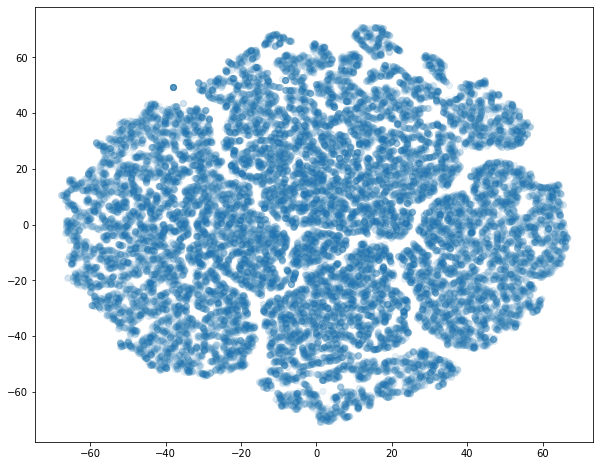

In [111]:
# df_subset['tsne-2d-one'] = df_tsne[:,0]
# df_subset['tsne-2d-two'] = df_tsne[:,1]
plt.figure(figsize=(10,8))
plt.scatter(x=x_tsne, y=y_tsne, alpha=0.05)


In [117]:
pca = PCA(n_components=2)
pca.fit(x)
existing_2d = pca.transform(x)

In [119]:
existing_df_2d = pd.DataFrame(existing_2d)
existing_df_2d.index = x.index
existing_df_2d.columns = ['PC1','PC2']
existing_df_2d.head()

,PC1,PC2
18,2.081443,-0.143114
20,1.847485,-0.278279
21,3.235971,-0.241169
40,2.481156,1.528863
41,0.939989,-0.780850


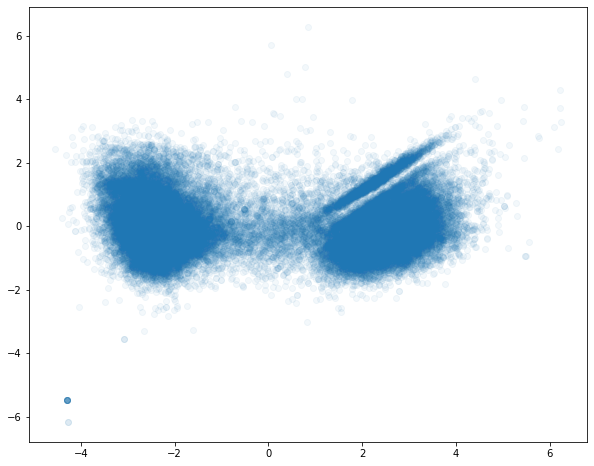

In [123]:
plt.figure(figsize=(10,8))
plt.scatter(x=existing_df_2d['PC1'], y=existing_df_2d['PC2'], alpha=0.05)